In [1]:
#Importing relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import icd
from prince import MCA
import prince
from prince import mca
import scipy.stats as stats
import seaborn as sns
import seaborn
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

Loading the original raw UK Biobank data-set consisting of 2149 leukaemia patients with their associated features (25,000) and patient IDs (eids)

In [2]:
sample_df = pd.read_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/leu.tsv", sep='\t', header=0, low_memory= 'False')
inferred_dtypes = sample_df.dtypes
dtype_dict = {}
for col, dtype in inferred_dtypes.items():
    dtype_dict[col] = dtype.name
df = pd.read_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/leu.tsv", sep='\t', dtype=dtype_dict, engine='python')

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\3597010048.py:1: DtypeWarning: Columns (19,20,21,23,24,25,29,30,31,98,99,100,106,107,108,110,111,451,453,454,478,479,735,736,737,739,740,741,751,752,753,755,756,757,775,776,777,779,780,781,783,784,785,814,815,816,818,819,820,822,823,824,826,827,828,829,830,831,833,834,835,838,839,840,842,843,844,846,847,848,870,871,872,874,875,876,878,879,880,882,883,884,886,887,888,890,891,892,898,899,900,902,903,904,906,907,908,910,911,912,914,915,916,918,919,920,922,923,924,926,927,928,930,931,932,958,959,960,962,963,964,966,967,968,970,971,972,974,975,976,978,979,980,982,983,984,986,987,988,990,991,992,994,995,996,1002,1003,1004,1010,1011,1012,1014,1015,1016,1026,1027,1028,1030,1031,1032,1038,1039,1040,1042,1043,1044,1046,1047,1048,1070,1071,1072,1074,1075,1076,1078,1079,1081,1082,1084,1085,1087,1088,1090,1091,1093,1094,1096,1097,1102,1103,1105,1106,1107,1109,1110,1111,1113,1114,1116,1117,1119,1120,1121,1127,1128,1129,1143,1144,1145,11

Loading in the subset data consisting of patients with AML,CML, ALL, CLL, EXCLUSIVELY. All patients with multiple leukaemia sub-type diagnoses were excluded from further analysis.

In [3]:
subset_data= pd.read_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/subset_data.csv", sep= ',', header= 0)

In [4]:
#setting 'eid' or the patient ID column as the index
subset_data= subset_data.set_index('eid')

subsetting the raw data frame to exclude misdiagnosed patients from further analysis.

In [5]:
df = df[df['eid'].isin(subset_data.index)]

Extracting the columns corresponding to the the three letter icd code assigned to each patient on each hospital inpatient admission. This information is available in the summary diagnosis field of the health-related outcomes category in the UK Biobank web interface.

In [6]:
icd_columns= df.columns[df.columns.str.contains('f41270_0')]
icd_df= df[['eid'] + list(icd_columns)]

In [7]:
#Data frame consisting of the icd codes assigned to each patient on each inpatient admission
icd_df

,eid,diagnoses_icd10_f41270_0_0,diagnoses_icd10_f41270_0_1,diagnoses_icd10_f41270_0_2,diagnoses_icd10_f41270_0_3,diagnoses_icd10_f41270_0_4,diagnoses_icd10_f41270_0_5,diagnoses_icd10_f41270_0_6,diagnoses_icd10_f41270_0_7,diagnoses_icd10_f41270_0_8,...,diagnoses_icd10_f41270_0_213,diagnoses_icd10_f41270_0_214,diagnoses_icd10_f41270_0_215,diagnoses_icd10_f41270_0_216,diagnoses_icd10_f41270_0_217,diagnoses_icd10_f41270_0_218,diagnoses_icd10_f41270_0_219,diagnoses_icd10_f41270_0_220,diagnoses_icd10_f41270_0_221,diagnoses_icd10_f41270_0_222
0,1002912,C819,C920,D45,D471,E538,E831,I219,I269,I802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1002951,A499,B029,C829,C859,C900,C911,D509,D70,D801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1005217,C921,E119,K562,K573,M109,M189,M202,M2577,R195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1009538,C64,C911,I849,K610,S208,V496,Z511,Z855,Z905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1009715,A047,A099,A419,C920,C931,D121,D123,D70,F171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,6006271,A419,C920,D70,E119,E780,E875,F059,G629,I10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2145,6018053,C911,D693,D695,D801,K011,R51,Z857,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2146,6020766,C508,C921,D509,D649,E86,E871,E875,F329,G439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2147,6024287,B972,C444,C911,H024,H269,H402,H409,H521,J128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Ensure 'eid' is of integer type to avoid dtype issues later
icd_df['eid'] = icd_df['eid'].astype(int)

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\375752368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icd_df['eid'] = icd_df['eid'].astype(int)


In [9]:
#Extracting the column corresponding to the sex of the patient a
sex_columns= df.columns[df.columns.str.contains('f31_0')]
sex_df= df[['eid'] + list(sex_columns)]

In [10]:
#Extracting the column corresponding to the index of multiple deprivation (IMD) score.
imd_columns= df.columns[df.columns.str.contains('f26410')]
imd_df= df[['eid'] + list(imd_columns)]

In [11]:
#Extracting the column containing the age of death (where applicable) for each patient
death_columns= df.columns[df.columns.str.contains('f40007_0')]
death_df= df[['eid'] + list(death_columns)]

Making a dictionary with the specific leukaemia type as the key and the corresponding icd code/codes as values.

In [12]:
leukemia_dict= {
    'AML': 'C920',
    'CML': 'C910',
    'ALL': 'C911',
    'CLL': 'C921',
    'ML': ['C92', 'C920', 'C920', 'C921', 'C922', 'C923', 'C924', 'C925', 'C926', 'C927', 'C928', 'C929'],
    'LL':  ['C91', 'C910', 'C910', 'C911', 'C912', 'C913', 'C914', 'C915', 'C916', 'C917', 'C918', 'C919'],
    'Acute': ['C920', 'C910'],
    'Chronic': ['C921', 'C911']}

Creating a function to iterate over each row in the icd_df data frame, and assigning the leukaemia type to the patient if an ICD corresponding to one of the leukaemia types appeared in any of the columns.

In [13]:
def determine_leukemia_types(row, leukemia_dict):
    result = {}
    for leukemia_type, icd_codes in leukemia_dict.items():
        #if the value in the dictionary is a single code
        #the eid corresponding to that value will be assigned that code
        if isinstance(icd_codes, str):  
            result[leukemia_type] = icd_codes in str(row.values)
        #if the value in the dictionary is a list of codes
        #if any value in the list is encountered in one of the row, that value will be assigned to the eid 
        elif isinstance(icd_codes, list):  
            result[leukemia_type] = any(icd_code in str(row.values) for icd_code in icd_codes)
    return result


Creating a data frame leukaemia_types_df containing boolean values indicating the presence or absence of each leukaemia type. Merging the leukaemia_types_df with the icd_df.

In [14]:
leukemia_types_list = []
for _, row in icd_df.iterrows():
    leukemia_types_list.append(determine_leukemia_types(row, leukemia_dict))
leukemia_types_df = pd.DataFrame(leukemia_types_list)

# Concatenate the results with the original DataFrame
icd_df = pd.concat([icd_df.reset_index(drop=True), leukemia_types_df.reset_index(drop=True)], axis=1)


In [15]:
#icd_df dataframe
icd_df

,eid,diagnoses_icd10_f41270_0_0,diagnoses_icd10_f41270_0_1,diagnoses_icd10_f41270_0_2,diagnoses_icd10_f41270_0_3,diagnoses_icd10_f41270_0_4,diagnoses_icd10_f41270_0_5,diagnoses_icd10_f41270_0_6,diagnoses_icd10_f41270_0_7,diagnoses_icd10_f41270_0_8,...,diagnoses_icd10_f41270_0_221,diagnoses_icd10_f41270_0_222,AML,CML,ALL,CLL,ML,LL,Acute,Chronic
0,1002912,C819,C920,D45,D471,E538,E831,I219,I269,I802,...,NaN,NaN,True,False,False,False,True,False,True,False
1,1002951,A499,B029,C829,C859,C900,C911,D509,D70,D801,...,NaN,NaN,False,False,True,False,False,True,False,True
2,1005217,C921,E119,K562,K573,M109,M189,M202,M2577,R195,...,NaN,NaN,False,False,False,True,True,False,False,True
3,1009538,C64,C911,I849,K610,S208,V496,Z511,Z855,Z905,...,NaN,NaN,False,False,True,False,False,True,False,True
4,1009715,A047,A099,A419,C920,C931,D121,D123,D70,F171,...,NaN,NaN,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,6006271,A419,C920,D70,E119,E780,E875,F059,G629,I10,...,NaN,NaN,True,False,False,False,True,False,True,False
1801,6018053,C911,D693,D695,D801,K011,R51,Z857,NaN,NaN,...,NaN,NaN,False,False,True,False,False,True,False,True
1802,6020766,C508,C921,D509,D649,E86,E871,E875,F329,G439,...,NaN,NaN,False,False,False,True,True,False,False,True
1803,6024287,B972,C444,C911,H024,H269,H402,H409,H521,J128,...,NaN,NaN,False,False,True,False,False,True,False,True


In [16]:
#creating a new dataframe, leuk_df from the leukaemia_types_df, consisting of only AML, CML, CLL and ALL columns
leuk_df=leukemia_types_df.drop(columns=['ML'])
leuk_df=leuk_df.drop(columns=['Acute'])
leuk_df=leuk_df.drop(columns=['Chronic'])
leuk_df=leuk_df.drop(columns=['LL'])
leuk_df['eid']= icd_df['eid']
leuk_df= leuk_df.set_index('eid')

In [17]:
#replacing the nan values with an empty string
icd_df[icd_columns]= icd_df[icd_columns].fillna('').astype(str)

Using the icd package to map the codes in the icd_df dataframe to 17 broad comorbidities defined by charlson.

In [18]:
charl= icd.icd_to_comorbidities(icd_df, 'eid', icd_columns, mapping="charlson10")

In [19]:
#dropping the extra eid column
charl= charl.drop(charl.columns[-1], axis=1)

In [20]:
charl

,myocardial_infarction,congestive_heart_failure,periphral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,connective_tissue_disease_rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_wo_complications,diabetes_w_complications,paraplegia_and_hemiplegia,renal_disease,cancer,moderate_or_sever_liver_disease,metastitic_carcinoma,aids_hiv
eid,,,,,,,,,,,,,,,,,
1002912,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1002951,True,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False
1005217,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
1009538,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1009715,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6006271,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False
6018053,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
6020766,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False


creating a function to return a master table containing the comorbidity, sex, deprivation and age of death information.

In [21]:
def create_master(comor, sex_df, imd_df, death_df):
    """
    Merge multiple dataframes into comor_unsub_charl and return the resulting dataframe.
    
    Parameters:
    comor (pd.DataFrame): The main dataframe to which other dataframes will be merged.
    sex_df (pd.DataFrame): DataFrame containing sex information.
    imd_df (pd.DataFrame): DataFrame containing index of multiple deprivation information.
    death_df (pd.DataFrame): DataFrame containing age at death information.
    
    Returns:
    pd.DataFrame: The merged dataframe with the appropriate columns set as index.
    """
    #Merge type of leukemia information
    comor= comor.merge(leuk_df[['AML', 'CML', 'ALL', 'CLL']], left_index=True, right_on= 'eid')
    
    # Merge sex information
    comor = comor.merge(sex_df[['eid', 'sex_f31_0_0']], left_index=True, right_on='eid')
    comor = comor.set_index('eid')
    
    # Merge index of multiple deprivation information
    comor = comor.merge(imd_df[['eid', 'index_of_multiple_deprivation_england_f26410_0_0']], left_index=True, right_on='eid')
    comor = comor.set_index('eid')
    
    # Merge age at death information
    comor = comor.merge(death_df[['eid', 'age_at_death_f40007_0_0']], left_index=True, right_on='eid')
    comor = comor.set_index('eid')
    
    return comor



In [22]:
#applying the create_master function for charlson comorbidities
charl_master= create_master(charl, sex_df, imd_df, death_df)

In [23]:
charl_master

,myocardial_infarction,congestive_heart_failure,periphral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,connective_tissue_disease_rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_wo_complications,...,moderate_or_sever_liver_disease,metastitic_carcinoma,aids_hiv,AML,CML,ALL,CLL,sex_f31_0_0,index_of_multiple_deprivation_england_f26410_0_0,age_at_death_f40007_0_0
eid,,,,,,,,,,,,,,,,,,,,,
1002912,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,Male,NaN,62.4
1002951,True,False,False,True,False,True,False,False,False,True,...,False,False,False,False,False,True,False,Male,NaN,NaN
1005217,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,Male,10.35,NaN
1009538,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,Male,NaN,NaN
1009715,False,False,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,Male,NaN,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6006271,False,False,False,True,False,False,False,False,False,True,...,False,False,False,True,False,False,False,Male,60.84,70.5
6018053,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,Female,18.46,NaN
6020766,False,False,False,False,False,False,False,False,True,False,...,True,False,False,False,False,False,True,Female,9.27,75.2


Creating a function to plot the variance explained by each component for the multiple corresponding analysis using the prince package to create an 'elbow plot'. This will determine the the number of components explaining the most variance to be selected for the final MCA.

In [24]:
def plot_mca_explained_variance(comor, comor_columns):
    """
    Plot the variance explained by each component in Multiple Correspondence Analysis (MCA).

    Parameters:
    comor_unsub_charl (pd.DataFrame): The input dataframe containing the data.
    comor_columns (list): The list of columns to be used for MCA.

    Returns:
    None
    """
    #Initialising an empty list to store cumulative variance explained by each range of components
    n_components_range = range(1, len(comor_columns) + 1)  
    cumulative_explained_variances = []

    #PErforming MCA on various number of components (All combinations from 1 to 17)
    for n_components in n_components_range:
        mca = MCA(n_components=n_components)
        mca.fit(comor[comor_columns])
        #Appending the list with the cumulative variance recorded by each successive number of components
        cumulative_explained_variances.append(sum(mca.percentage_of_variance_))

    #calculating the variance explained by each component by subtracting from the previous one
    explained_variances = [cumulative_explained_variances[0]]  
    for i in range(1, len(cumulative_explained_variances)):
        explained_variances.append(cumulative_explained_variances[i] - cumulative_explained_variances[i-1])

    print("Explained variances by each component:", explained_variances)

    plt.figure(figsize=(10, 7))
    plt.plot(n_components_range, explained_variances, marker='o')
    plt.xlabel('Component Number')
    plt.ylabel('Variance Explained')
    plt.title('Variance Explained by Each Component in MCA')
    plt.xticks(n_components_range)
    plt.grid(True)
    plt.show()


Explained variances by each component: [12.99229971125493, 9.143200320450077, 8.504453272958536, 7.343929923511631, 6.785307107615587, 6.6525888459198015, 6.4060483315953505, 6.244877738589842, 6.048715447006202, 5.678681911291022, 5.506206087566611, 5.263932104377204, 4.752698504287906, 4.606902928597805, 4.070157764976642, 1.1368683772161603e-13, -8.526512829121202e-14]


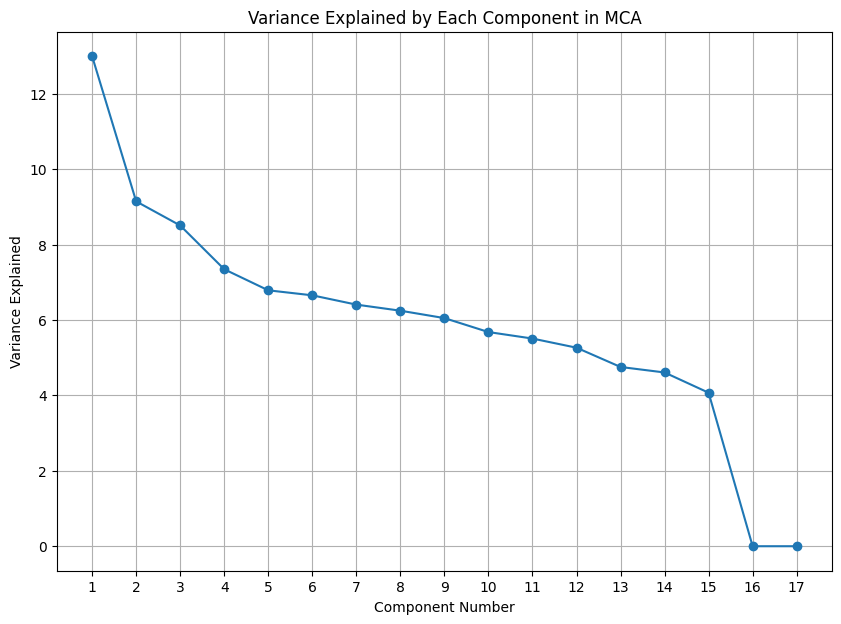

In [25]:
#extracting charlson comorbidity columns from the charl_master table
comor_columns_charl = charl_master.columns[0:17]
plot_mca_explained_variance(charl_master, comor_columns_charl)

Mapping true/False boolean values in charl_master table where applicable to prepare the data for multiple correspondence analysis.

In [26]:
columns_to_map = charl_master.iloc[:, 0:17].columns
for column in columns_to_map:
    charl_master[column] = charl_master[column].map({True: 1, False: 0})
charl_master['sex_f31_0_0']= charl_master['sex_f31_0_0'].map({'Male':0, 'Female':1})

Multiple correspondence analysis

In [27]:
mca= prince.MCA(n_components=4)
mca= mca.fit(charl_master[comor_columns_charl])

In [28]:
#Adding the coordinates of the first four principle components as seperate columns in the master table
coordinates = mca.transform(charl_master[comor_columns_charl])
charl_master['PC1'] = coordinates.iloc[:, 0]
charl_master['PC2'] = coordinates.iloc[:, 1]
charl_master['PC3'] = coordinates.iloc[:, 2]
charl_master['PC4'] = coordinates.iloc[:, 3]

Creating a function to plot principle components from the mca analysis.

In [29]:

  def plot_mca(charl_master):     
        plot_pairs= [
            ('PC1', 'PC2'),
            ('PC1', 'PC3'),
            ('PC1', 'PC4'),
            ('PC2', 'PC3'),
            ('PC2', 'PC4'),
            ('PC3', 'PC4')
        ]
        
        titles = [
            'PC1 vs PC2',
            'PC1 vs PC3',
            'PC1 vs PC4',
            'PC2 vs PC3',
            'PC2 vs PC4',
            'PC3 vs PC4'
        ]
        
        
        for (x, y), title in zip(plot_pairs, titles):
            plt.figure(figsize=(9, 6))
            sns.scatterplot(
                data=charl_master,
                x=x,
                y=y,
                hue='sex_f31_0_0',
                size='index_of_multiple_deprivation_england_f26410_0_0',
                sizes=(20, 200),
                palette={0: 'lightgreen', 1: 'lightcoral'}
            )
            plt.axhline(0, linestyle='--', color='black', linewidth=1)
            plt.axvline(0, linestyle='--', color='black', linewidth=1)
            plt.title(title)
            plt.legend(bbox_to_anchor=(1.05, 0.9), loc='upper left')
            plt.xlabel('PC2 [13.03%]')  # Add x-axis label
            plt.ylabel('PC3 [12.5%]')  # Add y-axis label
            #plt.legend(title='Gender', bbox_to_anchor=(1.05, 0.9), loc='upper left')
            #plt.tight_layout()
            plt.show()

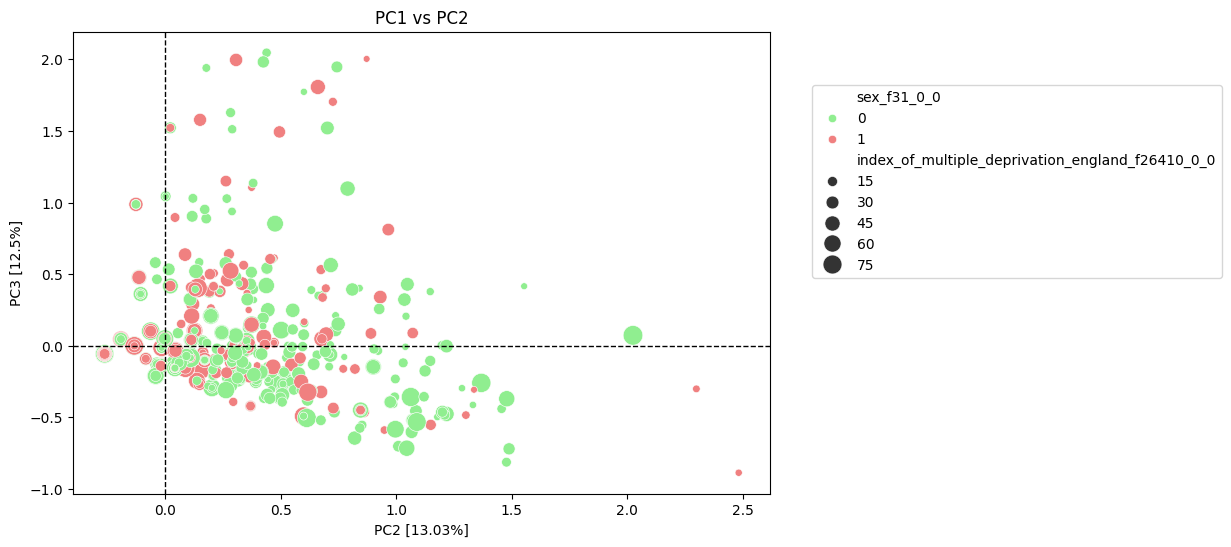

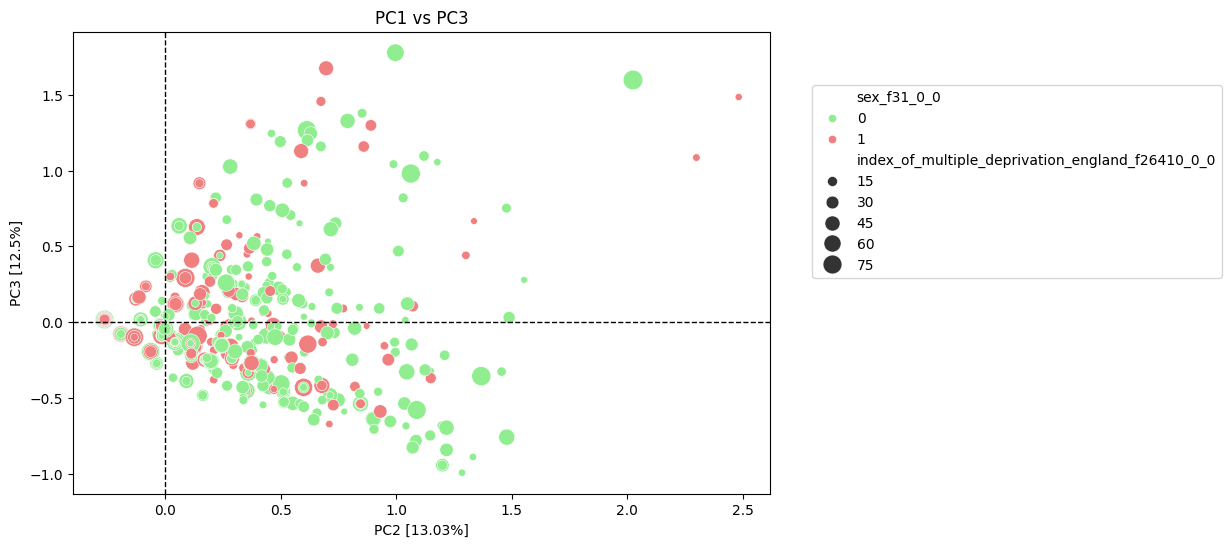

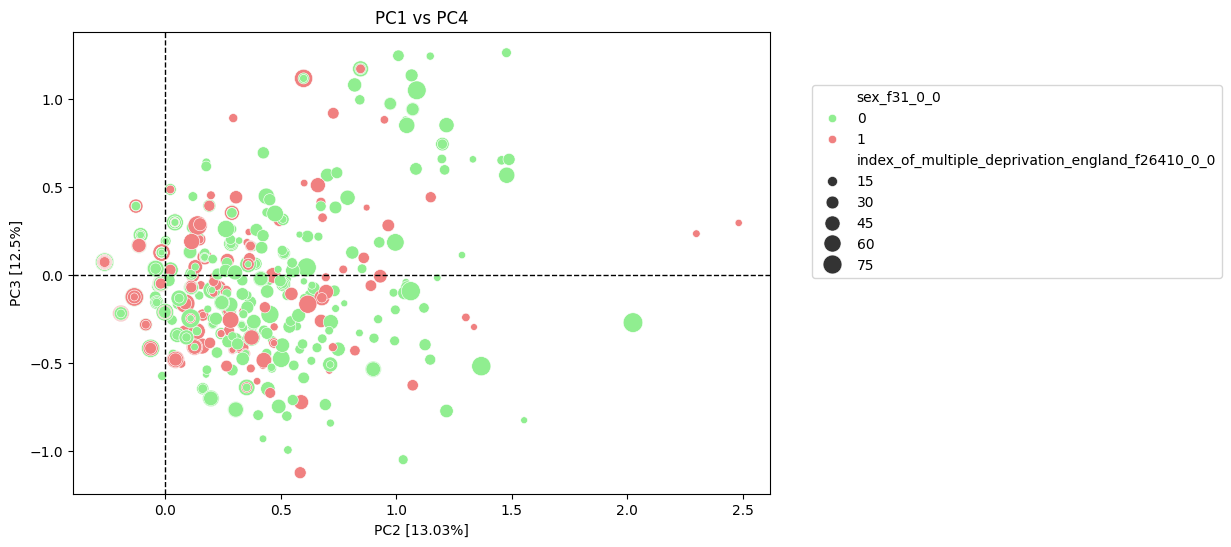

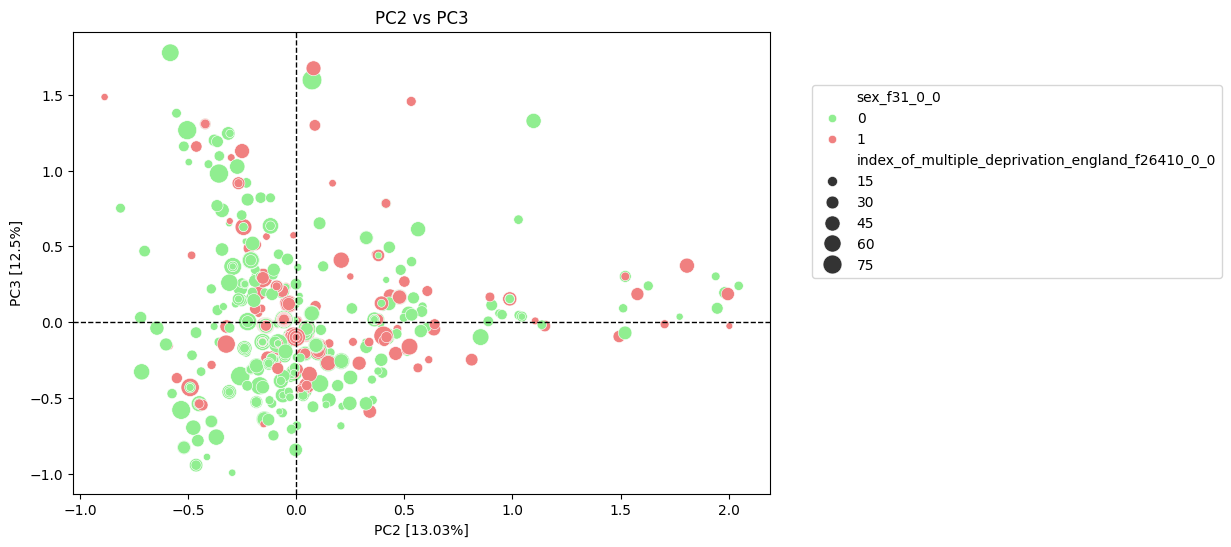

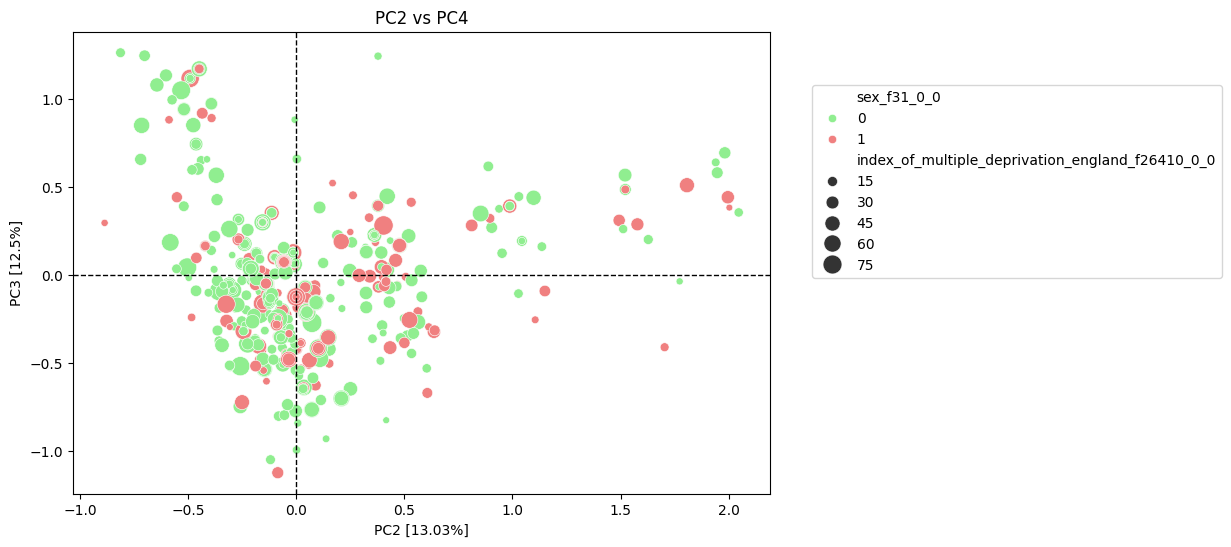

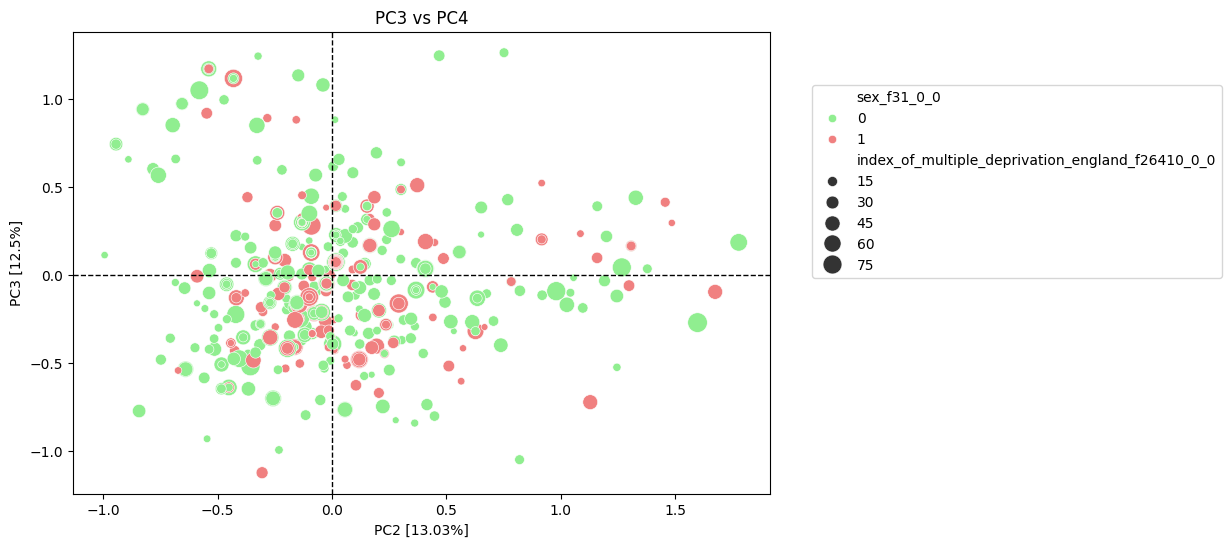

In [30]:
#Scatter plot for the PC2 and PC3 principle components
plot_mca(charl_master)

Using the elixhauser comorbidity parameter from the icd package to map summaru diagnosis.

In [31]:
quan= icd.icd_to_comorbidities(icd_df, 'eid', icd_columns, mapping="quan_elixhauser10")

In [32]:
quan= quan.drop(quan.columns[-1], axis=1)

In [33]:
quan_master= create_master(quan, sex_df, imd_df, death_df)

In [34]:
quan_master.columns

Index(['congestive_heart_failure', 'cardiac_arrhythmia', 'valvular_disease',
       'pulmonary_circulation_disorder', 'peripheral vascular_disorder',
       'hypertension_uncomplicated', 'hypertension_complicated', 'paralysis',
       'other_neurological_disorder', 'chronic_pulmonary_disease',
       'diabetes_uncomplicated', 'diabetes_complicated', 'hypothyroidism',
       'renal_failure', 'liver_disease',
       'peptic_ulcer_disease_excluding_bleeding', 'aids_hiv', 'lymphoma',
       'metastatic_cancer', 'solid_tumor_wo_metastasis', 'rheumatoid_arhritis',
       'coagulopathy', 'obesity', 'weight_loss',
       'fluid_and_electrolyte_disorders', 'blood_loss_anemia',
       'deficiency_anemia', 'alcohol_abuse', 'drug_abuse', 'psychoses',
       'depression', 'AML', 'CML', 'ALL', 'CLL', 'sex_f31_0_0',
       'index_of_multiple_deprivation_england_f26410_0_0',
       'age_at_death_f40007_0_0'],
      dtype='object')

Elixhauser contains 31 comorbidities and these were utilised to perform the mca.

Explained variances by each component: [9.423068179542328, 5.142824764502722, 4.822113381942128, 4.175116746215782, 3.99129369733469, 3.91295262136126, 3.8867053394665163, 3.693311413617117, 3.619249306973302, 3.4354589940455043, 3.367277945038694, 3.327336203538522, 3.2718276717966646, 3.249705041542697, 3.1437575161595603, 3.0722423142280277, 3.0289940698707625, 3.0160044524063068, 2.901025285339898, 2.72758932448113, 2.710235911481348, 2.625168145150539, 2.583850163216354, 2.504154389693767, 2.3299675765517947, 2.2760648237287313, 2.170048364036518, 2.0035657975071217, 1.836630550503088, 1.752460008727283, 7.105427357601002e-14]


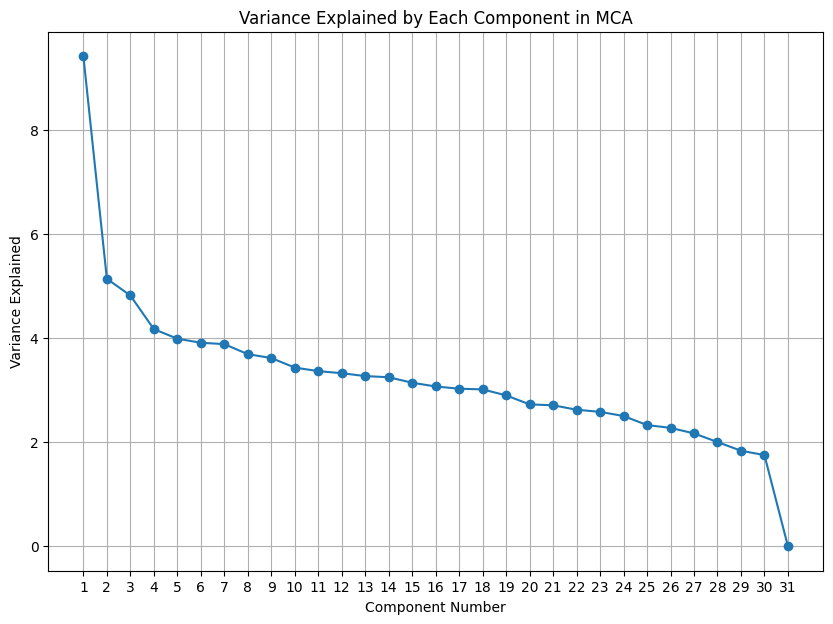

In [35]:
comor_columns_quan = quan_master.columns[0:31]
#applying the plot variance function for the quan mca
plot_mca_explained_variance(quan_master, comor_columns_quan)

Mapping true/false boolean values to 0/1 for elixhauser comorbidities.

In [36]:
columns_to_map = quan_master.iloc[:, 0:31].columns
for column in columns_to_map:
    quan_master[column] = quan_master[column].map({True: 1, False: 0})
quan_master['sex_f31_0_0']= quan_master['sex_f31_0_0'].map({'Male':0, 'Female':1})

In [37]:
mca= prince.MCA(n_components=6)
mca= mca.fit(quan_master[comor_columns_quan])

In [38]:
quan_master[comor_columns_quan]

,congestive_heart_failure,cardiac_arrhythmia,valvular_disease,pulmonary_circulation_disorder,peripheral vascular_disorder,hypertension_uncomplicated,hypertension_complicated,paralysis,other_neurological_disorder,chronic_pulmonary_disease,...,coagulopathy,obesity,weight_loss,fluid_and_electrolyte_disorders,blood_loss_anemia,deficiency_anemia,alcohol_abuse,drug_abuse,psychoses,depression
eid,,,,,,,,,,,,,,,,,,,,,
1002912,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1002951,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,1,0,0,0,0
1005217,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1009538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1009715,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6006271,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6018053,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6020766,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1


In [39]:
#Adding the coordinates of the first 6 principle components in the quan comorbidity data frame
coordinates = mca.transform(quan_master[comor_columns_quan])
quan_master['PC1'] = coordinates.iloc[:, 0]
quan_master['PC2'] = coordinates.iloc[:, 1]
quan_master['PC3'] = coordinates.iloc[:, 2]
quan_master['PC4'] = coordinates.iloc[:, 3]
quan_master['PC5'] = coordinates.iloc[:, 4]
quan_master['PC6'] = coordinates.iloc[:, 5]


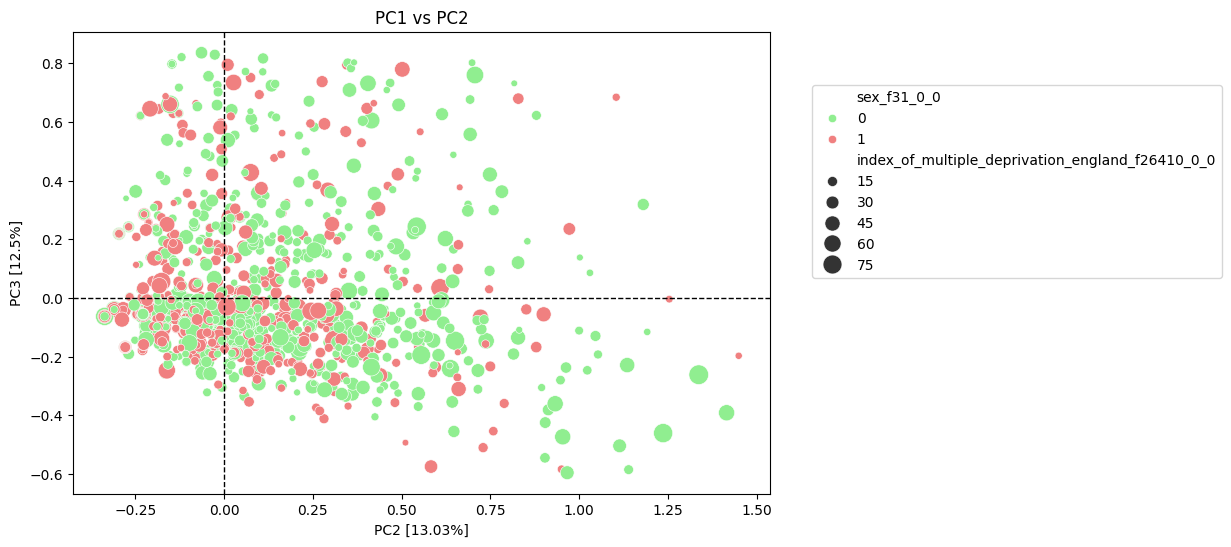

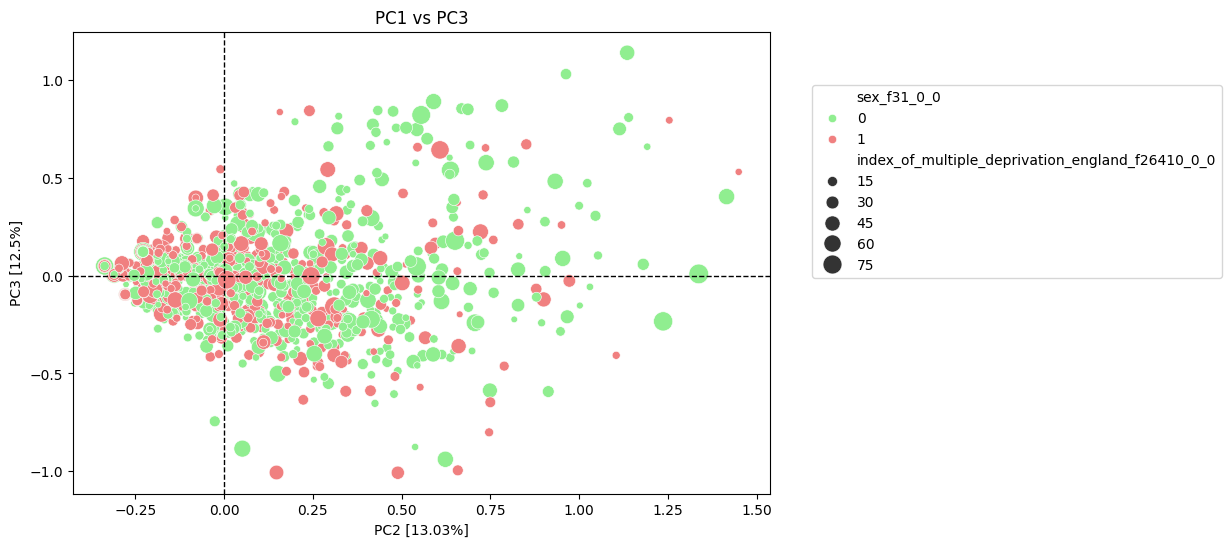

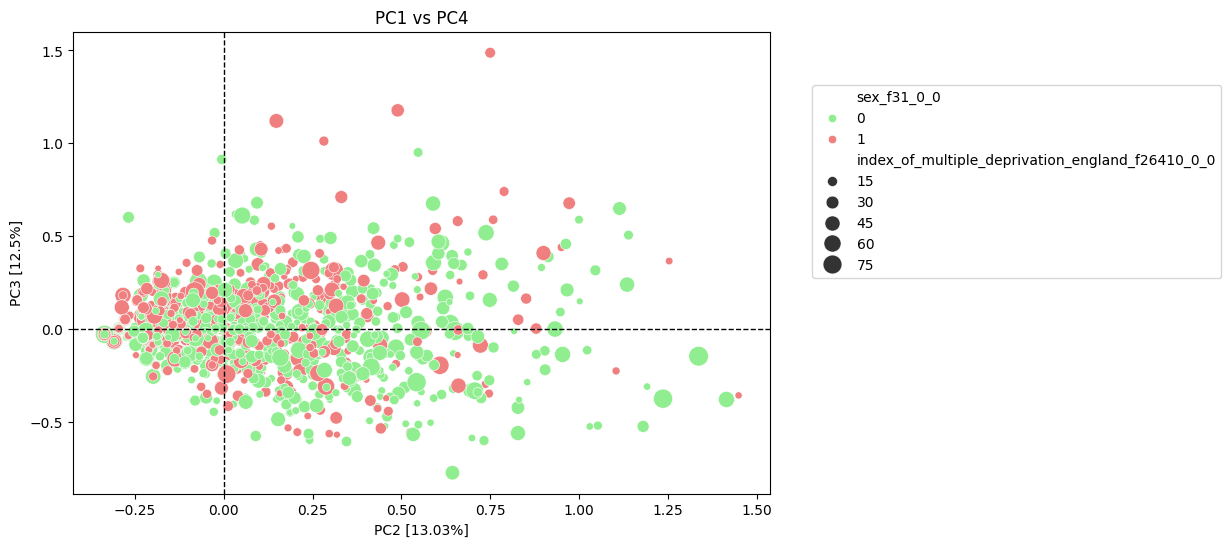

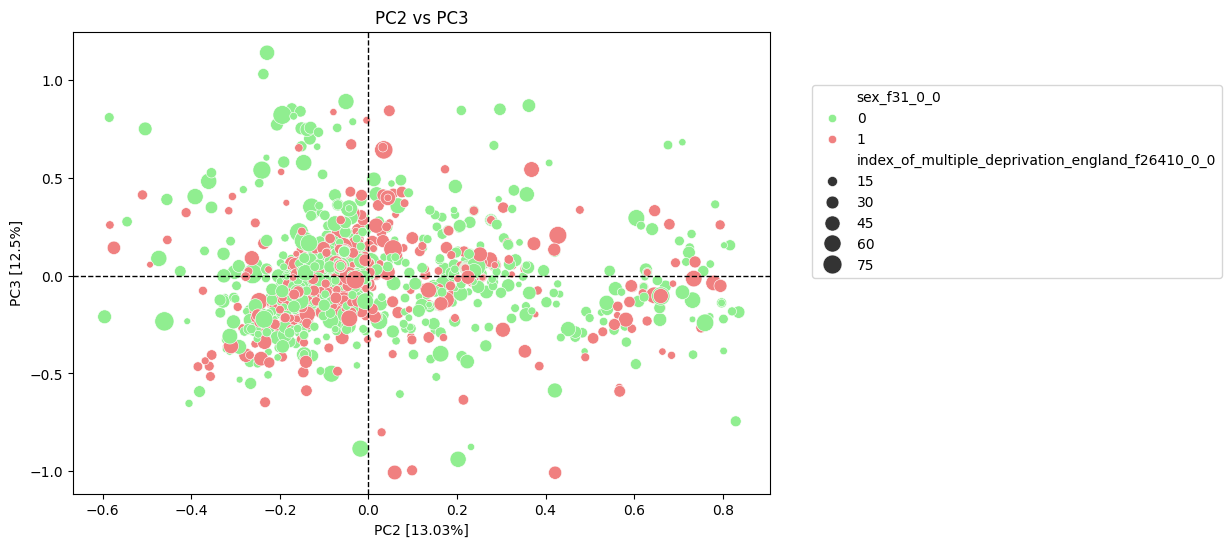

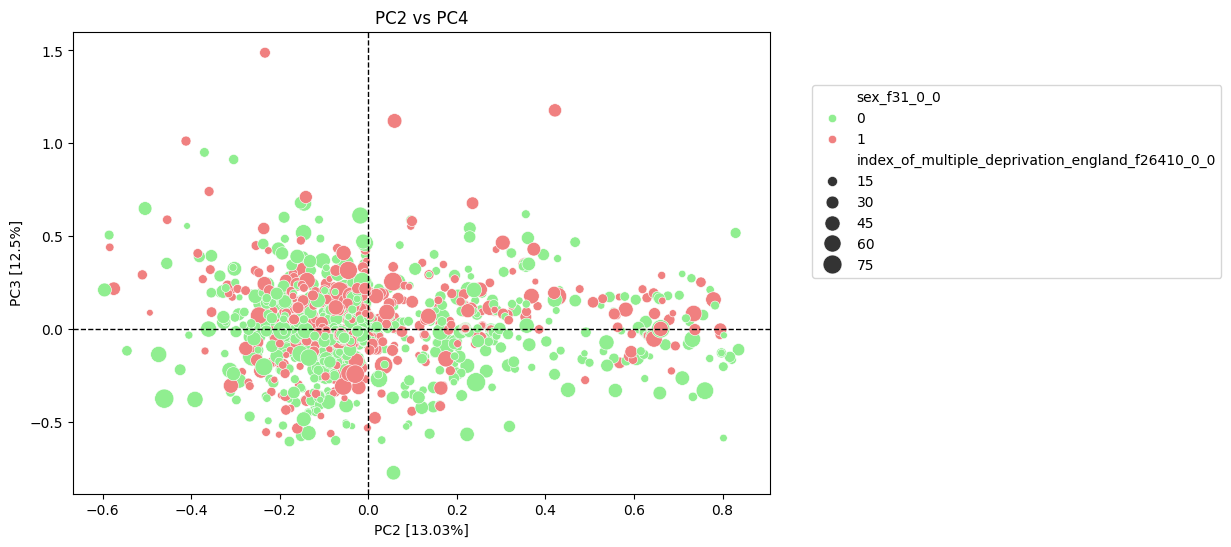

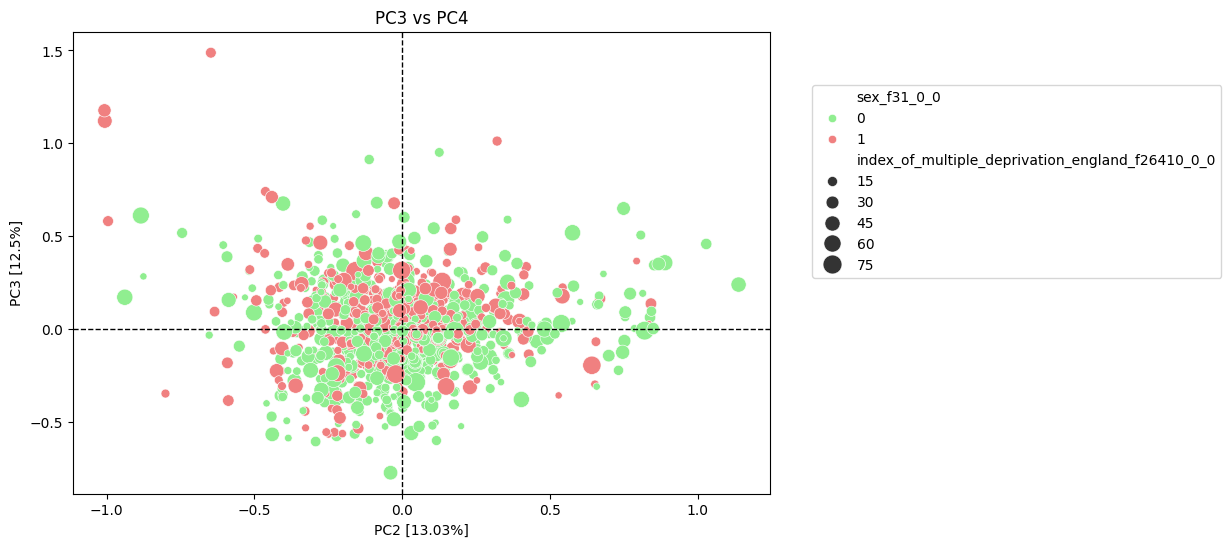

In [40]:
#Scatter plot for the PC1 and PC2 principle components of the Elixhauser MCA
plot_mca(quan_master)

The first occurence field in the hospital inpatient category of the UK Biobank data contains 16 fields dividing diseases into broad categories, each referred to as a chapter. Each chapter has certain icd codes associated with it based on the diseases. A custom mapping dictionary was created to store the chapters as key and the codes associated with it (taken from UK Biobank interface), as values.

In [41]:
def generate_icd10_codes(letter_ranges, number_ranges):
    code_dict = {}
    
    for letter, number_range in zip(letter_ranges, number_ranges):
        codes = []
        for i in range(number_range[0], number_range[1]):
            base_code = f"{letter}{i:02d}"
            codes.append(base_code)
            for digit in range(10):
                new_code = f"{base_code}{digit}"
                codes.append(new_code)
        code_dict[f"{letter}_codes"] = codes
    
    return code_dict

# Defining the ranges for the letters and numbers
letter_ranges = ["A", "B", "D", "E", "F", "G", "H_eye", "H_ear", "I", "J", "K", "L", "M", "N", "O", "P", "Q"]
number_ranges = [
    (0, 100),  # A
    (0, 100),  # B
    (50, 90),  # D
    (0, 91),   # E
    (0, 100),  # F
    (0, 100),  # G
    (0, 60),   # H_eye
    (60, 96),  # H_ear
    (0, 100),  # I
    (0, 100),  # J
    (0, 100),  # K
    (0, 100),  # L
    (0, 100),  # M
    (0, 100),  # N
    (0, 100),  # O
    (0, 100),  # P
    (0, 100)   # Q
]

# Generating the ICD-10 codes
icd10_codes = generate_icd10_codes(letter_ranges, number_ranges)

# Printing the generated codes for one category as an example
print(f"Example: {len(icd10_codes['A_codes'])} codes for 'A': {icd10_codes['A_codes'][:10]}")


Example: 1100 codes for 'A': ['A00', 'A000', 'A001', 'A002', 'A003', 'A004', 'A005', 'A006', 'A007', 'A008']


In [42]:
codes_dict = {
    'infectious_parasitic': [],
    'blood': [],
    'endocrine': [],
    'mental': [],
    'nervous': [],
    'eye': [],
    'ear': [],
    'circulatory': [],
    'respiratory': [],
    'digestive': [],
    'skin': [],
    'muscle': [],
    'genitourinary': [],
    'pregnancy': [],
    'perinatal': [],
    'congenital': []
}

category_mapping = {
    'infectious_parasitic': 'A_codes',
    'blood': 'B_codes',
    'endocrine': 'E_codes',
    'mental': 'F_codes',
    'nervous': 'G_codes',
    'eye': 'H_eye_codes',
    'ear': 'H_ear_codes',
    'circulatory': 'I_codes',
    'respiratory': 'J_codes',
    'digestive': 'K_codes',
    'skin': 'L_codes',
    'muscle': 'M_codes',
    'genitourinary': 'N_codes',
    'pregnancy': 'O_codes',
    'perinatal': 'P_codes',
    'congenital': 'Q_codes'
}

# Assign the codes to the appropriate chapters
for chapter, code_key in category_mapping.items():
    if code_key in icd10_codes:
        codes_dict[chapter] = icd10_codes[code_key]

Using the codes dict dictionary for the mapping parameter to map summary diagnosis codes to the first occurence chapters

In [43]:
#first_occur= icd.icd_to_comorbidities(icd_df, 'eid', icd_columns, mapping= codes_dict)

In [44]:
#reading the mapped first occurence chapters file
first_occur= pd.read_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/comor3.csv.xls", sep= ',', header=0)
first_occur['eid']= icd_df['eid']
first_occur= first_occur.set_index('eid')

In [45]:
#Applying the create_master function to the first occurence comorbidity data
first_occur_master= create_master(first_occur, sex_df, imd_df, death_df)

Explained variances by each component: [18.950338478701163, 8.034351014845772, 6.509174902793003, 6.358954765966459, 6.294374545118238, 6.200599158940648, 5.812948684738679, 5.5106585084797, 5.412104627574635, 5.209319435276981, 5.13083557096401, 4.877170040821952, 4.797135684687248, 4.042572316546796, 3.800116308257742, 3.05934595628797]


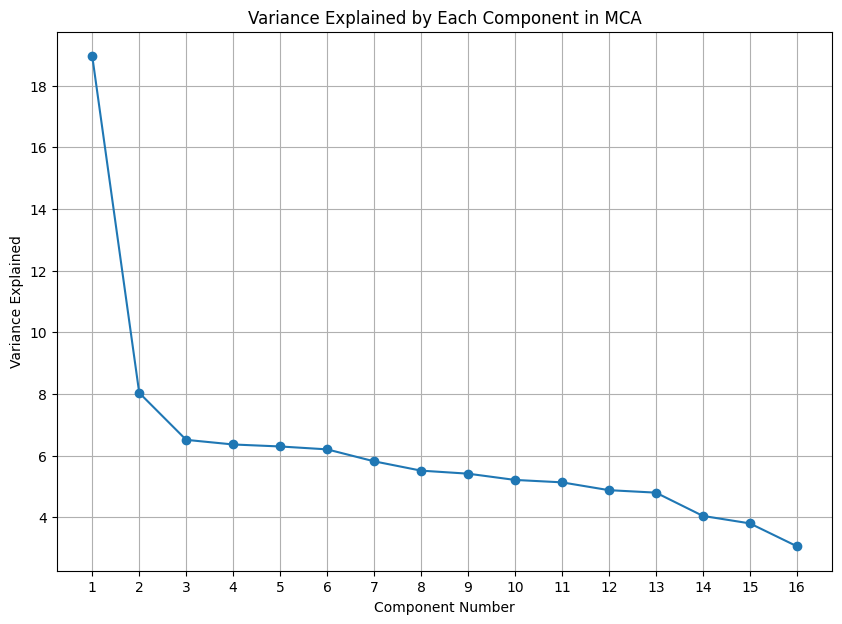

In [46]:
#Applying the plot variance explained function on the first occurence chapters
comor_columns_first_occur = first_occur_master.columns[0:16]
plot_mca_explained_variance(first_occur_master, comor_columns_first_occur)

In [47]:
#Mapping the boolean True/False values to 0/1
columns_to_map = first_occur_master.iloc[:, 0:16].columns
for column in columns_to_map:
    first_occur_master[column] = first_occur_master[column].map({True: 1, False: 0})
first_occur_master['sex_f31_0_0']= first_occur_master['sex_f31_0_0'].map({'Male':0, 'Female':1})

In [48]:
#Performing MCA on the first occurence data
mca= prince.MCA(n_components=6)
mca= mca.fit(first_occur_master[comor_columns_first_occur])

In [49]:
#Adding the coordinates of the principle components 
coordinates = mca.transform(first_occur_master[comor_columns_first_occur])
first_occur_master['PC1'] = coordinates.iloc[:, 0]
first_occur_master['PC2'] = coordinates.iloc[:, 1]
first_occur_master['PC3'] = coordinates.iloc[:, 2]
first_occur_master['PC4'] = coordinates.iloc[:, 3]

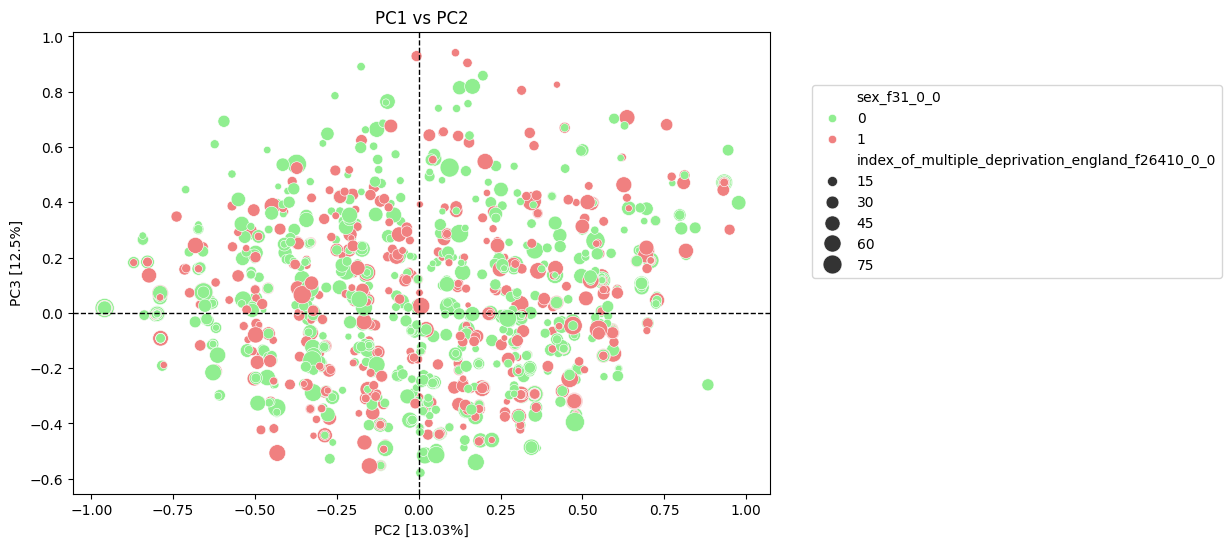

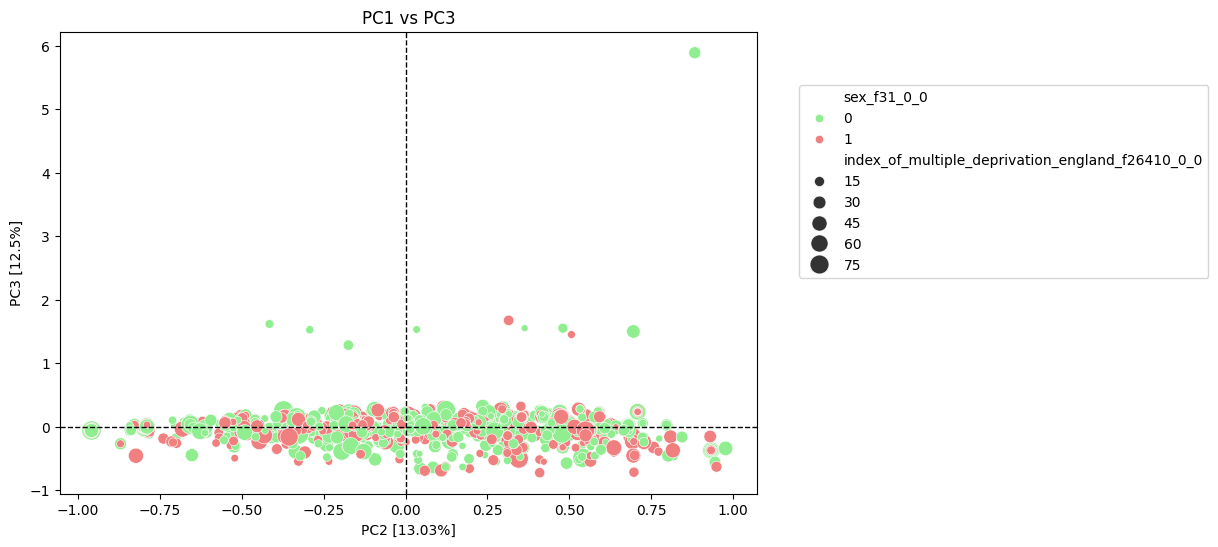

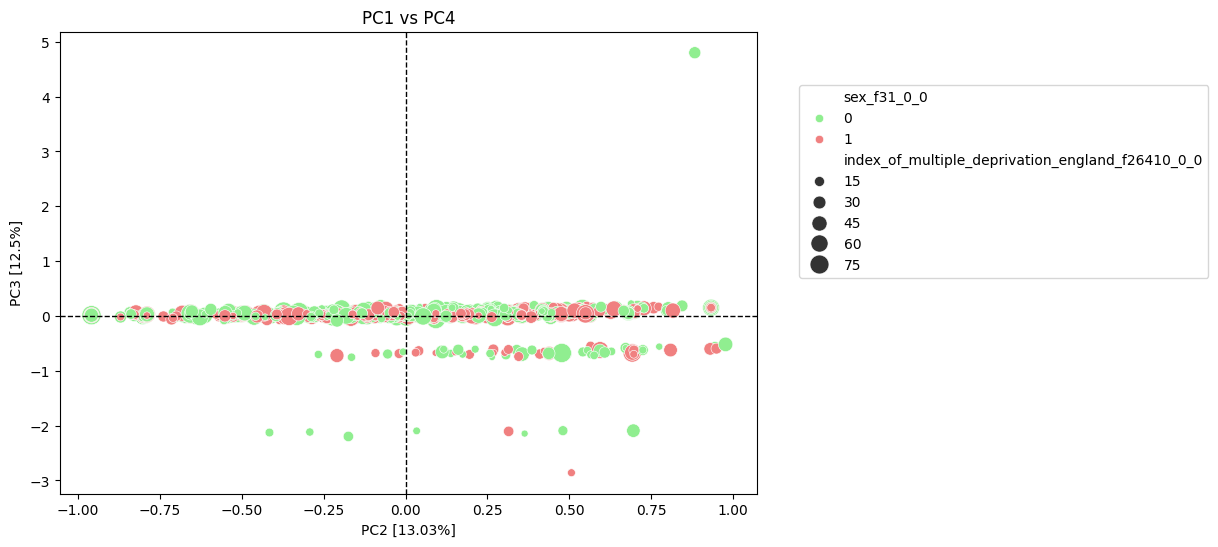

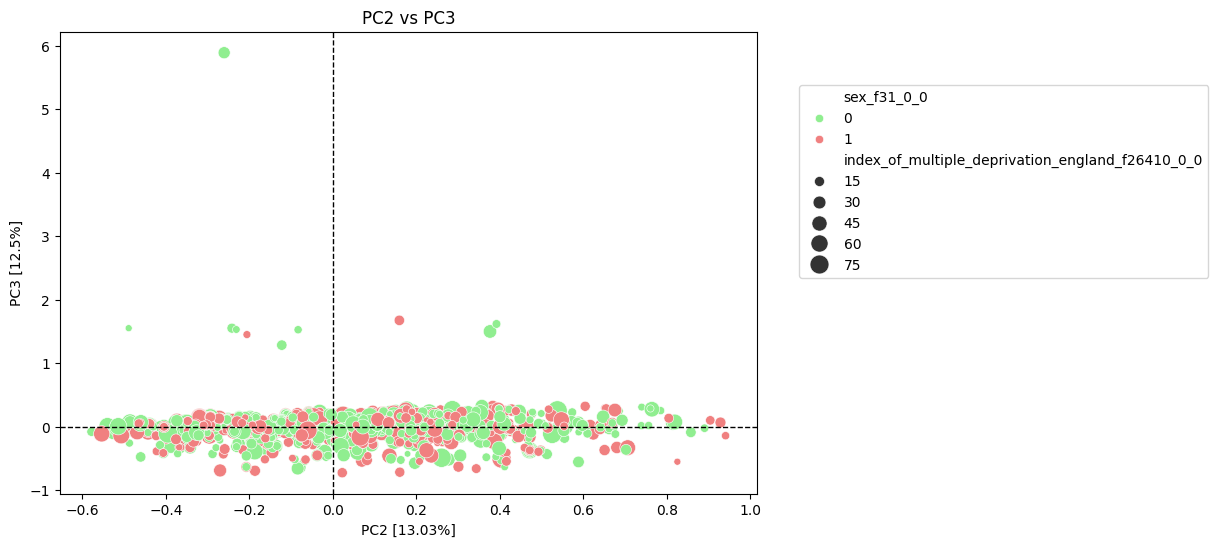

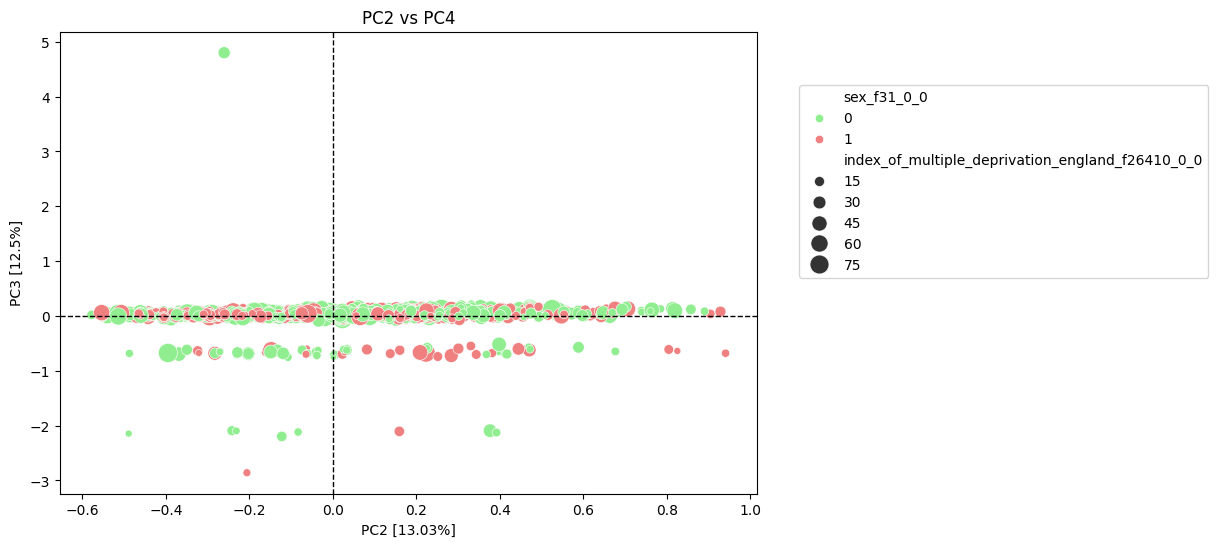

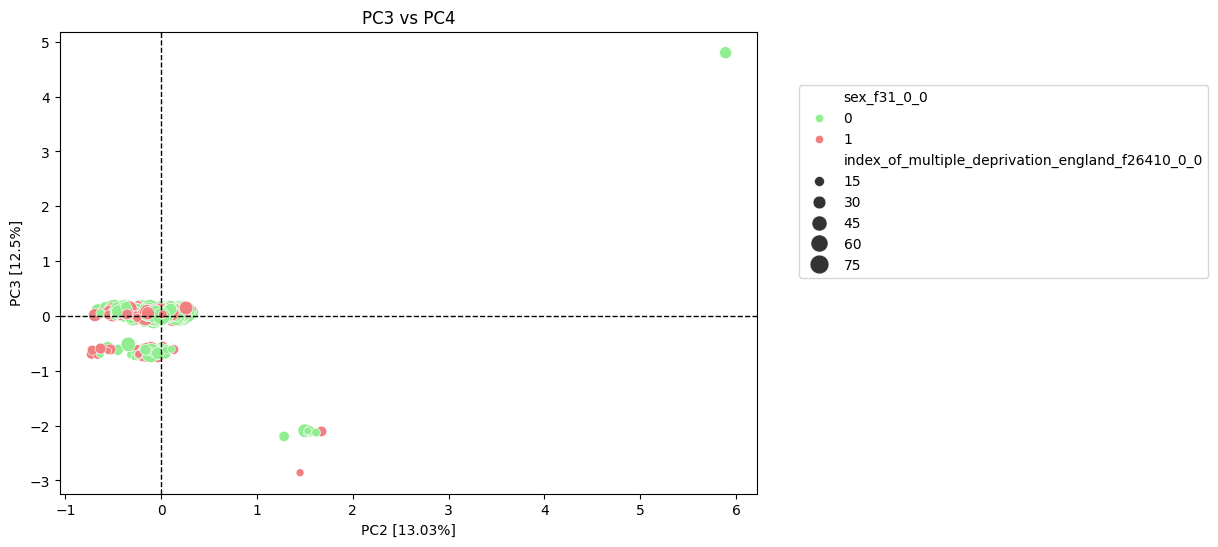

In [50]:
plot_mca(first_occur_master)

Evaluating the distribution curve (log) of the index of multiple deprivation data for each patient 

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\94380300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imd_df['log_imd'] = np.log(imd_df['index_of_multiple_deprivation_england_f26410_0_0'].replace(0, np.nan))


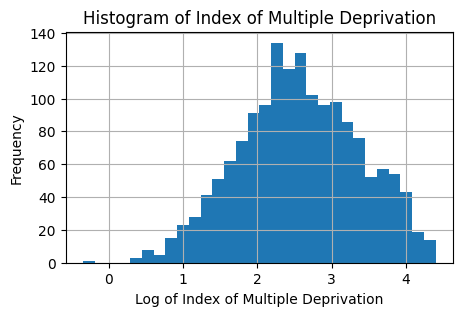

In [51]:
imd_df['log_imd'] = np.log(imd_df['index_of_multiple_deprivation_england_f26410_0_0'].replace(0, np.nan))

plt.figure(figsize=(5, 3))  # Width and height in inches

# Plot the histogram
imd_df['log_imd'].hist(bins=30)  # You can adjust the number of bins as needed

# Add labels and title
plt.xlabel('Log of Index of Multiple Deprivation')
plt.ylabel('Frequency')
plt.title('Histogram of Index of Multiple Deprivation')

# Show the plot
plt.show()

Categoring the first 25th percentile as low deprivation while the remaining 75th percentile as high deprivation

In [52]:
imd_df['category']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.25,1], labels= ['low', 'high'])

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\3758549599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imd_df['category']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.25,1], labels= ['low', 'high'])


Merging the category column from the imd_df with all comorbidity tables (quan, Elixhauser and first occurence)

In [53]:
quan_master = quan_master.merge(imd_df[['eid', 'category']], on='eid')
quan_master= quan_master.set_index('eid')

In [54]:
charl_master = charl_master.merge(imd_df[['eid', 'category']], on='eid')
charl_master= charl_master.set_index('eid')

In [55]:
first_occur_master = first_occur_master.merge(imd_df[['eid', 'category']], on='eid')
first_occur_master= first_occur_master.set_index('eid')

In [56]:
quan_master= quan_master.reset_index('eid')
quan_master.to_csv('quan_master_subset.csv', index=False)

In [57]:
charl_master= charl_master.reset_index('eid')
charl_master.to_csv('charl_master_subset.csv', index=False)

In [58]:
first_occur_master= first_occur_master.reset_index('eid')
first_occur_master.to_csv('first_occur_master_subset.csv', index=False)

Perfoming a bivariate chi-square test grouped by category on each of the individual comorbidity/chapters such as Charlson, Elixhauser and first occurence chapters.

In [59]:
#Excluding the columns containing continuous variables
columns_to_analyze = charl_master.columns.difference(['index_of_multiple_deprivation_england_f26410_0_0', 'age_at_death_f40007_0_0', 'category', 'cci', 'PC1', 'PC2', 'PC3', 'PC4', 'eid' ])

In [60]:
#Coverting the results from chi-square test on each comorbidity into a data frame
results = []
for column in columns_to_analyze:
    ct = pd.crosstab(index=charl_master[column], columns=charl_master['category'], margins=False)
    chi2, p, dof, expected = chi2_contingency(ct)
    result_dict = {
        'Condition': column,
        'Chi-squared test statistic': chi2,
        'p-value': p,
        'Degrees of freedom': dof,
        }
    results.append(result_dict)

results_df = pd.DataFrame(results)

#sorting the results by p-value
results_df.sort_values('p-value')


,Condition,Chi-squared test statistic,p-value,Degrees of freedom
12,diabetes_wo_complications,5.233692,0.022153,1
19,periphral_vascular_disease,3.102652,0.078165,1
15,moderate_or_sever_liver_disease,2.348941,0.125368,1
14,mild_liver_disease,2.294640,0.129821,1
13,metastitic_carcinoma,2.169527,0.140770,1
7,chronic_pulmonary_disease,1.822149,0.177058,1
20,renal_disease,1.437142,0.230602,1
8,congestive_heart_failure,0.866248,0.351996,1
3,CML,0.756926,0.384292,1
9,connective_tissue_disease_rheumatic_disease,0.548610,0.458886,1


In [61]:
columns_to_analyze = quan_master.columns.difference(['index_of_multiple_deprivation_england_f26410_0_0', 'age_at_death_f40007_0_0', 'category', 'cci', 'PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6' 'eid' ])

In [62]:
results = []
for column in columns_to_analyze:
    ct = pd.crosstab(index=quan_master[column], columns=quan_master['category'], margins=False)
    chi2, p, dof, expected = chi2_contingency(ct)
    result_dict = {
        'Condition': column,
        'Chi-squared test statistic': chi2,
        'p-value': p,
        'Degrees of freedom': dof,
        }
    results.append(result_dict)

results_df = pd.DataFrame(results)

results_df.sort_values('p-value')


,Condition,Chi-squared test statistic,p-value,Degrees of freedom
25,obesity,5.581321,0.018153,1
15,diabetes_uncomplicated,5.233692,0.022153,1
13,depression,4.848324,0.027673,1
22,liver_disease,4.683455,0.030454,1
18,fluid_and_electrolyte_disorders,3.985562,0.045892,1
29,peripheral vascular_disorder,3.102652,0.078165,1
19,hypertension_complicated,2.928112,0.087049,1
20,hypertension_uncomplicated,2.788030,0.094971,1
6,alcohol_abuse,2.417012,0.120024,1
24,metastatic_cancer,2.169527,0.140770,1


In [63]:
columns_to_analyze = first_occur_master.columns.difference(['index_of_multiple_deprivation_england_f26410_0_0', 'age_at_death_f40007_0_0', 'category', 'cci', 'PC1', 'PC2', 'PC3', 'PC4', 'sex_f31_0_0' , 'eid'])

In [64]:
results = []
for column in columns_to_analyze:
    ct = pd.crosstab(index=first_occur_master[column], columns=first_occur_master['category'], margins=False)
    chi2, p, dof, expected = chi2_contingency(ct)
    result_dict = {
        'Condition': column,
        'Chi-squared test statistic': chi2,
        'p-value': p,
        'Degrees of freedom': dof,
        }
    results.append(result_dict)

results_df = pd.DataFrame(results)

results_df.sort_values('p-value')


,Condition,Chi-squared test statistic,p-value,Degrees of freedom
8,ear_codes,3.838484,0.050089,1
18,resp_codes,1.298517,0.254484,1
6,congenital_codes,1.031232,0.309869,1
17,pregnancy_codes,0.918694,0.337818,1
3,CML,0.756926,0.384292,1
4,blood_codes,0.751147,0.386113,1
12,inf_para_codes,0.633664,0.426014,1
11,genitourino_codes,0.385448,0.534702,1
13,mental_codes,0.297676,0.585343,1
10,eye_codes,0.286516,0.592462,1


In [65]:
first_occur_master= first_occur_master.set_index('eid')

In [66]:
first_occur_master.columns

Index(['inf_para_codes', 'blood_codes', 'endocrine_codes', 'mental_codes',
       'nervous_codes', 'eye_codes', 'ear_codes', 'circ_codes', 'resp_codes',
       'digestive_codes', 'skin_codes', 'muscle_codes', 'genitourino_codes',
       'pregnancy_codes', 'perinatal_codes', 'congenital_codes', 'AML', 'CML',
       'ALL', 'CLL', 'sex_f31_0_0',
       'index_of_multiple_deprivation_england_f26410_0_0',
       'age_at_death_f40007_0_0', 'PC1', 'PC2', 'PC3', 'PC4', 'category'],
      dtype='object')

In [67]:
comor_columns= first_occur_master.columns[0:16]
mca= prince.MCA(n_components=4)
mca= mca.fit(first_occur_master[comor_columns])

Saving the original comorbidity data frames for charlson, elixhauser and first occurrence.

In [68]:
charl= charl.reset_index('eid')
charl.to_csv('C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/charl_subset.csv', index=False)

In [69]:
quan= quan.reset_index('eid')
quan.to_csv('C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/quan_subset.csv', index=False)

In [70]:
first_occur= first_occur.reset_index('eid')
first_occur.to_csv('C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/first_occur_subset.csv', index=False)

In [71]:
leukemia_types_df.to_csv('C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/leukemia_types_df_subset.csv')

Statistical analysis on various covariates such as age of death and comorbdity index (CCI and ECI).
1. Linear Regression

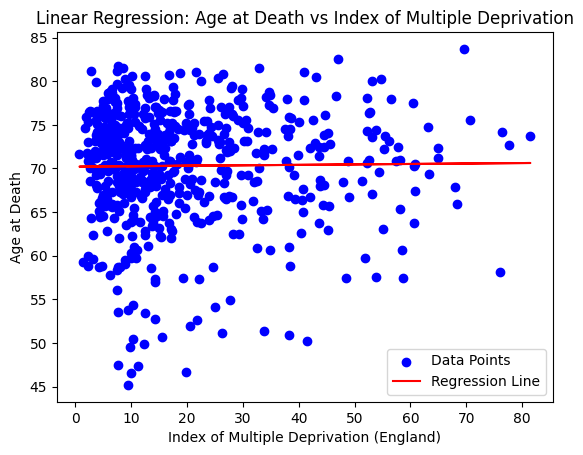

                               OLS Regression Results                              
Dep. Variable:     age_at_death_f40007_0_0   R-squared:                       0.000
Model:                                 OLS   Adj. R-squared:                 -0.002
Method:                      Least Squares   F-statistic:                   0.09103
Date:                     Sun, 18 Aug 2024   Prob (F-statistic):              0.763
Time:                             14:53:16   Log-Likelihood:                -1966.8
No. Observations:                      595   AIC:                             3938.
Df Residuals:                          593   BIC:                             3946.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

In [72]:
#dropping the null values
charl_master.dropna(subset=['index_of_multiple_deprivation_england_f26410_0_0', 'age_at_death_f40007_0_0'], inplace=True)

#Defining the X and Y variables as index of multiple deprivation and age of death respectively
Y = charl_master['age_at_death_f40007_0_0']
X = charl_master['index_of_multiple_deprivation_england_f26410_0_0']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

#prediction
predicted = model.predict(X)

#Creating the scatter plot
plt.scatter(charl_master['index_of_multiple_deprivation_england_f26410_0_0'], charl_master['age_at_death_f40007_0_0'], color='blue', label='Data Points')

#Creating the regression line
plt.plot(charl_master['index_of_multiple_deprivation_england_f26410_0_0'], predicted, color='red', label='Regression Line')

plt.xlabel('Index of Multiple Deprivation (England)')
plt.ylabel('Age at Death')
plt.title('Linear Regression: Age at Death vs Index of Multiple Deprivation')
plt.legend()

plt.show()

results = model.summary()
print(results)

Creating a function to calculate the charlson comorbidity index by assigning a score to each comorbidity and if any of the comorbidity columns is true for that comorbidity, it multiplies it by the specific score. The cumulative score is reported in a seperate column within the master table called CCI.

In [73]:
def cci(row):
    return (
        row['myocardial_infarction'] +
        row['congestive_heart_failure'] +
        row['periphral_vascular_disease'] +
        row['cerebrovascular_disease'] +
        row['dementia'] +
        row['chronic_pulmonary_disease'] +
        row['connective_tissue_disease_rheumatic_disease'] +
        row['peptic_ulcer_disease'] +
        row['mild_liver_disease'] +
        row['diabetes_wo_complications'] +
        row['diabetes_w_complications'] * 2 +
        row['paraplegia_and_hemiplegia'] * 2 +
        row['renal_disease'] * 2 +
        row['cancer'] +
        row['moderate_or_sever_liver_disease'] * 3 +
        row['metastitic_carcinoma'] * 6 +
        row['aids_hiv'] * 6
    )

In [74]:
charl_master['cci']=charl_master.apply(cci, axis =1)

In [75]:
charl_master

,eid,myocardial_infarction,congestive_heart_failure,periphral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,connective_tissue_disease_rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,...,CLL,sex_f31_0_0,index_of_multiple_deprivation_england_f26410_0_0,age_at_death_f40007_0_0,PC1,PC2,PC3,PC4,category,cci
5,1012930,0,0,0,0,0,0,0,0,0,...,False,0,26.68,68.3,-0.262462,-0.056791,0.016915,0.071557,high,1
8,1028806,1,1,0,0,0,1,0,0,0,...,False,0,14.28,77.1,0.657153,-0.064236,-0.599433,-0.414916,high,5
9,1030198,0,0,0,0,0,0,0,0,0,...,True,1,69.63,83.7,0.598968,-0.491031,-0.431287,1.115025,high,4
10,1031609,0,1,0,0,0,1,0,0,0,...,False,0,14.40,73.1,0.127060,0.105571,-0.162389,-0.410848,high,3
11,1042462,0,0,0,0,0,0,0,0,0,...,False,0,9.57,73.2,-0.262462,-0.056791,0.016915,0.071557,high,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786,5985822,0,0,0,0,0,1,0,0,0,...,False,1,70.72,75.6,-0.133777,-0.000729,-0.099762,-0.126462,high,2
1787,5986343,0,1,0,0,0,0,0,0,0,...,False,0,37.85,78.0,0.245053,0.091651,-0.153652,-0.158640,high,4
1797,6002018,0,0,0,0,0,0,0,0,0,...,False,0,25.79,73.0,0.452626,-0.366530,0.768479,0.425933,high,4
1800,6006271,0,0,0,1,0,0,0,0,0,...,False,0,60.84,70.5,0.263141,-0.309606,0.260071,0.259887,high,3


Performing a t-test for charlson comorbidity index between low and high groups of deprivation to evaluate the significance.

In [76]:
low_group_cci= charl_master[charl_master['category']== 'low']['cci'].dropna()
high_group_cci= charl_master[charl_master['category']== 'high']['cci'].dropna()

In [77]:
# Perform the t-test
t_stat, p_value = stats.ttest_ind(low_group_cci, high_group_cci, equal_var=True)  # use equal_var=False for Welch's t-test if variances are unequal

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -1.343540384920226
P-value: 0.17961094201806516


In [78]:
def elixhauser(row):
    return (
        row['congestive_heart_failure'] * 7 +
        row['cardiac_arrhythmia'] * 5 +
        row['valvular_disease'] * 4 +
        row['pulmonary_circulation_disorder'] * 6 +
        row['peripheral vascular_disorder'] * 5 +
        row['hypertension_uncomplicated'] * 2 +
        row['hypertension_complicated'] * 4 +
        row['paralysis'] * 5 +
        row['other_neurological_disorder'] * 6 +
        row['chronic_pulmonary_disease'] * 3 +
        row['diabetes_uncomplicated'] * 4 +
        row['diabetes_complicated'] * 6 +
        row['hypothyroidism'] * 3 +
        row['renal_failure'] * 6 +
        row['liver_disease'] * 5 +
        row['peptic_ulcer_disease_excluding_bleeding'] * 4 +
        row['aids_hiv'] * 7 +
        row['lymphoma'] * 8 +
        row['metastatic_cancer'] * 9 +
        row['solid_tumor_wo_metastasis'] * 8 +
        row['rheumatoid_arhritis'] * 4 +
        row['coagulopathy'] * 5 +
        row['obesity'] * 3 +
        row['weight_loss'] * 6 +
        row['fluid_and_electrolyte_disorders'] * 7 +
        row['blood_loss_anemia'] * 4 +
        row['deficiency_anemia'] * 3 +
        row['alcohol_abuse'] * 5 +
        row['drug_abuse'] * 5 +
        row['psychoses'] * 4 +
        row['depression'] * 3
    )

In [79]:
quan_master['eci']=quan_master.apply(elixhauser, axis =1)

In [80]:
quan_master

,eid,congestive_heart_failure,cardiac_arrhythmia,valvular_disease,pulmonary_circulation_disorder,peripheral vascular_disorder,hypertension_uncomplicated,hypertension_complicated,paralysis,other_neurological_disorder,...,index_of_multiple_deprivation_england_f26410_0_0,age_at_death_f40007_0_0,PC1,PC2,PC3,PC4,PC5,PC6,category,eci
0,1002912,0,0,0,1,0,0,0,0,0,...,NaN,62.4,-0.220395,0.136736,-0.077191,-0.176707,0.121997,-0.357558,NaN,14
1,1002951,0,0,0,0,0,0,0,0,0,...,NaN,NaN,0.276871,-0.115483,0.014296,0.114716,0.526433,0.076909,NaN,31
2,1005217,0,0,0,0,0,0,0,0,0,...,10.35,NaN,-0.187683,-0.051835,0.269783,-0.029940,0.041083,0.002334,high,4
3,1009538,0,0,0,0,0,0,0,0,0,...,NaN,NaN,-0.295500,0.219023,0.036872,0.003453,0.007641,-0.017579,NaN,8
4,1009715,0,0,0,0,0,0,0,0,0,...,NaN,60.0,-0.148781,-0.005910,-0.066426,0.084993,-0.038103,0.305422,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,6006271,0,1,0,0,0,1,0,0,0,...,60.84,70.5,0.159183,-0.134102,0.164871,-0.152776,0.006038,-0.006975,high,18
1801,6018053,0,0,0,0,0,0,0,0,0,...,18.46,NaN,-0.278014,-0.167548,-0.096502,0.052758,-0.004049,-0.104914,high,5
1802,6020766,0,1,0,0,0,1,0,0,0,...,9.27,75.2,0.319188,0.195519,-0.216661,0.269793,0.114264,0.233204,high,33
1803,6024287,0,0,0,0,0,0,0,0,0,...,NaN,NaN,-0.336098,-0.062815,0.048651,-0.027483,0.010930,0.007777,NaN,0


Performing a t-test for elixhauser comorbidity index between low and high groups of deprivation to evaluate the significance.

In [81]:
low_group_eci= quan_master[quan_master['category']== 'low']['eci'].dropna()
high_group_eci= quan_master[quan_master['category']== 'high']['eci'].dropna()

In [82]:
# Perform the t-test
t_stat, p_value = stats.ttest_ind(low_group_eci, high_group_eci, equal_var=True)  # use equal_var=False for Welch's t-test if variances are unequal

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -3.0483691469041663
P-value: 0.0023392279370389527


In [83]:
low_group_age= charl_master[charl_master['category']== 'low']['age_at_death_f40007_0_0'].dropna()
high_group_age= charl_master[charl_master['category']== 'high']['age_at_death_f40007_0_0'].dropna()

In [84]:
# Perform the t-test
t_stat, p_value = stats.ttest_ind(low_group_age, high_group_age, equal_var=True)  # use equal_var=False for Welch's t-test if variances are unequal

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 2.387993739550106
P-value: 0.01725263174939359


PLotting a violin Plot for ECI and CCI versus high/low deprivation.

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\1770076113.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='category', y='cci', data=charl_master, palette='Pastel1')
C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\1770076113.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = charl_master.groupby('category')['cci'].median()


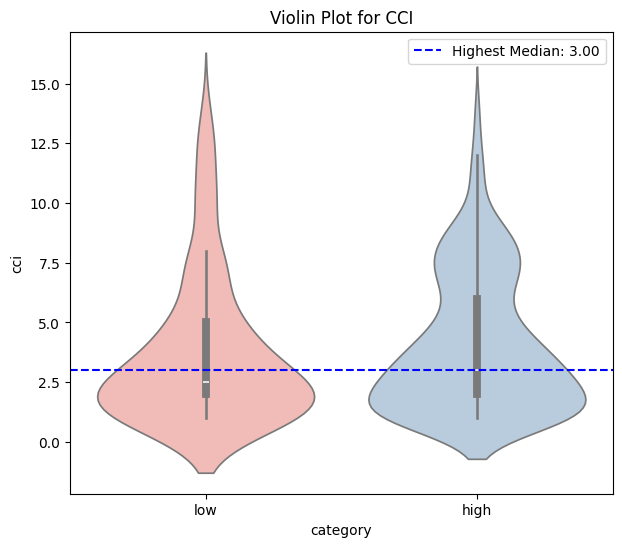

In [85]:
plt.figure(figsize=(7, 6))

# Creating a violin plot with a custom color palette
sns.violinplot(x='category', y='cci', data=charl_master, palette='Pastel1')

# Calculating the medians for each category
medians = charl_master.groupby('category')['cci'].median()

# Finding the highest median value
max_median = medians.max()

# Adding a horizontal line at the highest median value
plt.axhline(y=max_median, color='blue', linestyle='--', label=f'Highest Median: {max_median:.2f}')

# Setting the title of the plot
plt.title('Violin Plot for CCI')

# Adding a legend in the upper right corner
plt.legend(loc='upper right')

plt.show()


C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\3195077931.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='category', y='eci', data=quan_master, palette='pink')
C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\3195077931.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = quan_master.groupby('category')['eci'].median()


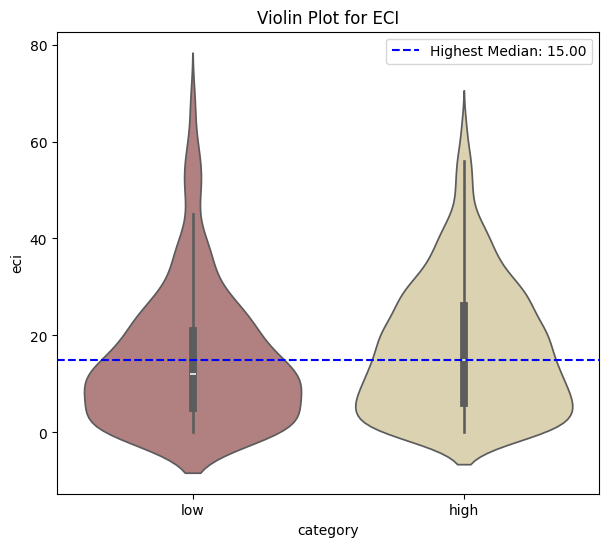

In [86]:
# Set the figure size
plt.figure(figsize=(7, 6))

# Creating a violin plot with a custom color palette
sns.violinplot(x='category', y='eci', data=quan_master, palette='pink')

# Calculating the medians for each category
medians = quan_master.groupby('category')['eci'].median()

# Finding the highest median value
max_median = medians.max()

# Adding a horizontal line at the highest median value
plt.axhline(y=max_median, color='blue', linestyle='--', label=f'Highest Median: {max_median:.2f}')

# Setting the title of the plot
plt.title('Violin Plot for ECI')

# Adding a legend
plt.legend(loc='upper right')

plt.show()

This analysis includes calculating the frequency of patients for the presence of each charlson/elixhauser comorbidities, leukaemia subtypes (ALL, CLL, AML and CML) and sex, meaning all categorical variables.

In [87]:
category_sex = charl_master.groupby(['category', 'sex_f31_0_0']).size().reset_index(name='count')
category_mi = charl_master.groupby(['category', 'myocardial_infarction']).size().reset_index(name='count')
category_chs = charl_master.groupby(['category', 'congestive_heart_failure']).size().reset_index(name='count')
category_pvd = charl_master.groupby(['category', 'periphral_vascular_disease']).size().reset_index(name='count')
category_cvd = charl_master.groupby(['category', 'cerebrovascular_disease']).size().reset_index(name='count')
category_dem = charl_master.groupby(['category', 'dementia']).size().reset_index(name='count')
category_cpd = charl_master.groupby(['category', 'chronic_pulmonary_disease']).size().reset_index(name='count')
category_ctd = charl_master.groupby(['category', 'connective_tissue_disease_rheumatic_disease']).size().reset_index(name='count')
category_pu = charl_master.groupby(['category', 'peptic_ulcer_disease']).size().reset_index(name='count')
category_ml = charl_master.groupby(['category', 'mild_liver_disease']).size().reset_index(name='count')
category_dwoc = charl_master.groupby(['category', 'diabetes_wo_complications']).size().reset_index(name='count')
category_dwc = charl_master.groupby(['category', 'diabetes_w_complications']).size().reset_index(name='count')
category_plegia = charl_master.groupby(['category', 'paraplegia_and_hemiplegia']).size().reset_index(name='count')
category_renal = charl_master.groupby(['category', 'renal_disease']).size().reset_index(name='count')
category_cancer = charl_master.groupby(['category', 'cancer']).size().reset_index(name='count')
category_sl = charl_master.groupby(['category', 'moderate_or_sever_liver_disease']).size().reset_index(name='count')
category_met = charl_master.groupby(['category', 'metastitic_carcinoma']).size().reset_index(name='count')
category_aids = charl_master.groupby(['category', 'aids_hiv']).size().reset_index(name='count')
category_aml = charl_master.groupby(['category', 'AML']).size().reset_index(name='count')
category_cml = charl_master.groupby(['category', 'CML']).size().reset_index(name='count')
category_all = charl_master.groupby(['category', 'ALL']).size().reset_index(name='count')
category_cll = charl_master.groupby(['category', 'CLL']).size().reset_index(name='count')


C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\1368584737.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sex = charl_master.groupby(['category', 'sex_f31_0_0']).size().reset_index(name='count')
C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\1368584737.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_mi = charl_master.groupby(['category', 'myocardial_infarction']).size().reset_index(name='count')
C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\1368584737.py:3: FutureWarning: The default of observed=False is deprecated and will be chang

In [88]:
charl_master

,eid,myocardial_infarction,congestive_heart_failure,periphral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,connective_tissue_disease_rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,...,CLL,sex_f31_0_0,index_of_multiple_deprivation_england_f26410_0_0,age_at_death_f40007_0_0,PC1,PC2,PC3,PC4,category,cci
5,1012930,0,0,0,0,0,0,0,0,0,...,False,0,26.68,68.3,-0.262462,-0.056791,0.016915,0.071557,high,1
8,1028806,1,1,0,0,0,1,0,0,0,...,False,0,14.28,77.1,0.657153,-0.064236,-0.599433,-0.414916,high,5
9,1030198,0,0,0,0,0,0,0,0,0,...,True,1,69.63,83.7,0.598968,-0.491031,-0.431287,1.115025,high,4
10,1031609,0,1,0,0,0,1,0,0,0,...,False,0,14.40,73.1,0.127060,0.105571,-0.162389,-0.410848,high,3
11,1042462,0,0,0,0,0,0,0,0,0,...,False,0,9.57,73.2,-0.262462,-0.056791,0.016915,0.071557,high,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786,5985822,0,0,0,0,0,1,0,0,0,...,False,1,70.72,75.6,-0.133777,-0.000729,-0.099762,-0.126462,high,2
1787,5986343,0,1,0,0,0,0,0,0,0,...,False,0,37.85,78.0,0.245053,0.091651,-0.153652,-0.158640,high,4
1797,6002018,0,0,0,0,0,0,0,0,0,...,False,0,25.79,73.0,0.452626,-0.366530,0.768479,0.425933,high,4
1800,6006271,0,0,0,1,0,0,0,0,0,...,False,0,60.84,70.5,0.263141,-0.309606,0.260071,0.259887,high,3


In [89]:
print(category_sex)

  category  sex_f31_0_0  count
0      low            0     90
1      low            1     48
2     high            0    301
3     high            1    156


In [90]:
print(category_mi)

  category  myocardial_infarction  count
0      low                      0    123
1      low                      1     15
2     high                      0    404
3     high                      1     53


In [91]:
print(category_chs)

  category  congestive_heart_failure  count
0      low                         0    107
1      low                         1     31
2     high                         0    373
3     high                         1     84


In [92]:
print(category_pvd)

  category  periphral_vascular_disease  count
0      low                           0    122
1      low                           1     16
2     high                           0    395
3     high                           1     62


In [93]:
print(category_cvd)

  category  cerebrovascular_disease  count
0      low                        0    111
1      low                        1     27
2     high                        0    383
3     high                        1     74


In [94]:
print(category_dem)

  category  dementia  count
0      low         0    132
1      low         1      6
2     high         0    441
3     high         1     16


In [95]:
print(category_cpd)

  category  chronic_pulmonary_disease  count
0      low                          0    105
1      low                          1     33
2     high                          0    332
3     high                          1    125


In [96]:
print(category_ctd)

  category  connective_tissue_disease_rheumatic_disease  count
0      low                                            0    128
1      low                                            1     10
2     high                                            0    428
3     high                                            1     29


In [97]:
print(category_pu)

  category  peptic_ulcer_disease  count
0      low                     0    128
1      low                     1     10
2     high                     0    425
3     high                     1     32


In [98]:
print(category_ml)

  category  mild_liver_disease  count
0      low                   0    126
1      low                   1     12
2     high                   0    411
3     high                   1     46


In [99]:
print(category_dwoc)

  category  diabetes_wo_complications  count
0      low                          0    120
1      low                          1     18
2     high                          0    369
3     high                          1     88


In [100]:
print(category_dwc)

  category  diabetes_w_complications  count
0      low                         0    132
1      low                         1      6
2     high                         0    441
3     high                         1     16


In [101]:
print(category_plegia)

  category  paraplegia_and_hemiplegia  count
0      low                          0    132
1      low                          1      6
2     high                          0    435
3     high                          1     22


In [102]:
print(category_renal)

  category  renal_disease  count
0      low              0    113
1      low              1     25
2     high              0    372
3     high              1     85


In [103]:
print(category_cancer)

  category  cancer  count
0      low       1    138
1     high       1    457


In [104]:
print(category_sl)

  category  moderate_or_sever_liver_disease  count
0      low                                0    135
1      low                                1      3
2     high                                0    432
3     high                                1     25


In [105]:
print(category_met)

  category  metastitic_carcinoma  count
0      low                     0    120
1      low                     1     18
2     high                     0    379
3     high                     1     78


In [106]:
print(category_aids)

  category  aids_hiv  count
0      low         0    138
1     high         0    457


In [107]:
print(category_aml)

  category    AML  count
0      low  False     57
1      low   True     81
2     high  False    216
3     high   True    241


In [108]:
print(category_cml)

  category    CML  count
0      low  False    133
1      low   True      5
2     high  False    436
3     high   True     21


In [109]:
print(category_all)

  category    ALL  count
0      low  False     90
1      low   True     48
2     high  False    294
3     high   True    163


In [110]:
print(category_cll)

  category    CLL  count
0      low  False    134
1      low   True      4
2     high  False    425
3     high   True     32


In [111]:
#Calculating the mean cci between high/low IMD groups
category_mean_cci = charl_master.groupby('category')['cci'].mean().reset_index(name='mean_cci')
print(category_mean_cci)

  category  mean_cci
0      low  3.673913
1     high  4.059081


C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\4216801352.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_mean_cci = charl_master.groupby('category')['cci'].mean().reset_index(name='mean_cci')


In [112]:
# Calculating the mean CCI for each category
category_mean_cci = charl_master.groupby('category')['cci'].mean().reset_index(name='mean_cci')

# Calculating the standard error for each category
category_sem = charl_master.groupby('category')['cci'].sem().reset_index(name='sem_cci')

# Merging the mean and SEM DataFrames
category_stats = category_mean_cci.merge(category_sem, on='category')

# Calculating the margin of error for 95% confidence interval (using z-score of 1.96)
category_stats['margin_of_error'] = 1.96 * category_stats['sem_cci']

# Calculating the lower and upper bounds of the 95% confidence interval
category_stats['ci_lower'] = category_stats['mean_cci'] - category_stats['margin_of_error']
category_stats['ci_upper'] = category_stats['mean_cci'] + category_stats['margin_of_error']

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\2348714182.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_mean_cci = charl_master.groupby('category')['cci'].mean().reset_index(name='mean_cci')
C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\2348714182.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sem = charl_master.groupby('category')['cci'].sem().reset_index(name='sem_cci')


In [113]:
category_stats

,category,mean_cci,sem_cci,margin_of_error,ci_lower,ci_upper
0,low,3.673913,0.261651,0.512836,3.161078,4.186749
1,high,4.059081,0.136299,0.267147,3.791934,4.326228


In [114]:
#Calculating the mean eci between high/low IMD groups
category_mean_eci = quan_master.groupby('category')['eci'].mean().reset_index(name='mean_eci')
print(category_mean_eci)

  category   mean_eci
0      low  14.837975
1     high  17.238983


C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\1943212342.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_mean_eci = quan_master.groupby('category')['eci'].mean().reset_index(name='mean_eci')


In [115]:
# Calculating the mean CCI for each category
category_mean_eci = quan_master.groupby('category')['eci'].mean().reset_index(name='mean_cci')

# Calculating the standard error for each category
category_sem_q = quan_master.groupby('category')['eci'].sem().reset_index(name='sem_cci')

# Merging the mean and SEM DataFrames
category_stats_q = category_mean_cci.merge(category_sem_q, on='category')

# Calculating the margin of error for 95% confidence interval (using z-score of 1.96)
category_stats_q['margin_of_error'] = 1.96 * category_stats_q['sem_cci']

# Calculating the lower and upper bounds of the 95% confidence interval
category_stats_q['ci_lower'] = category_stats_q['mean_cci'] - category_stats_q['margin_of_error']
category_stats_q['ci_upper'] = category_stats_q['mean_cci'] + category_stats_q['margin_of_error']


C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\2376905553.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_mean_eci = quan_master.groupby('category')['eci'].mean().reset_index(name='mean_cci')
C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\2376905553.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sem_q = quan_master.groupby('category')['eci'].sem().reset_index(name='sem_cci')


In [116]:
category_stats_q

,category,mean_cci,sem_cci,margin_of_error,ci_lower,ci_upper
0,low,3.673913,0.691712,1.355756,2.318157,5.029669
1,high,4.059081,0.392499,0.769297,3.289784,4.828378


In [117]:
#Calculating the mean age of death between high/low IMD groups
category_mean_age = quan_master.groupby('category')['age_at_death_f40007_0_0'].mean().reset_index(name='mean_age_of_death')
print(category_mean_age)

  category  mean_age_of_death
0      low          71.481884
1     high          69.956455


C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\2372074851.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_mean_age = quan_master.groupby('category')['age_at_death_f40007_0_0'].mean().reset_index(name='mean_age_of_death')


In [118]:
# Calculating the mean CCI for each category
category_mean_age = charl_master.groupby('category')['age_at_death_f40007_0_0'].mean().reset_index(name='mean_cci')

# Calculating the standard error for each category
category_sem_a = charl_master.groupby('category')['age_at_death_f40007_0_0'].sem().reset_index(name='sem_cci')

# Merging the mean and SEM DataFrames
category_stats_a = category_mean_age.merge(category_sem_a, on='category')

# Calculating the margin of error for 95% confidence interval (using z-score of 1.96)
category_stats_a['margin_of_error'] = 1.96 * category_stats_a['sem_cci']

# Calculating the lower and upper bounds of the 95% confidence interval
category_stats_a['ci_lower'] = category_stats_a['mean_cci'] - category_stats_a['margin_of_error']
category_stats_a['ci_upper'] = category_stats_a['mean_cci'] + category_stats_a['margin_of_error']


C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\252665147.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_mean_age = charl_master.groupby('category')['age_at_death_f40007_0_0'].mean().reset_index(name='mean_cci')
C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\252665147.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sem_a = charl_master.groupby('category')['age_at_death_f40007_0_0'].sem().reset_index(name='sem_cci')


In [119]:
category_stats_a

,category,mean_cci,sem_cci,margin_of_error,ci_lower,ci_upper
0,low,71.481884,0.438940,0.860322,70.621562,72.342206
1,high,69.956455,0.324955,0.636911,69.319544,70.593366


In [120]:
category_chs = quan_master.groupby(['category', 'congestive_heart_failure']).size().reset_index(name='count')
print(category_chs)
category_ca = quan_master.groupby(['category', 'cardiac_arrhythmia']).size().reset_index(name='count')
print(category_ca)
category_vd = quan_master.groupby(['category', 'valvular_disease']).size().reset_index(name='count')
print(category_vd)
category_pcd = quan_master.groupby(['category', 'pulmonary_circulation_disorder']).size().reset_index(name='count')
print(category_pcd)
category_pvd = quan_master.groupby(['category', 'peripheral vascular_disorder']).size().reset_index(name='count')
print(category_pvd)
category_hu = quan_master.groupby(['category', 'hypertension_uncomplicated']).size().reset_index(name='count')
print(category_hu)
category_hc = quan_master.groupby(['category', 'hypertension_complicated']).size().reset_index(name='count')
print(category_hc)
category_paralysis = quan_master.groupby(['category', 'paralysis']).size().reset_index(name='count')
print(category_paralysis)
category_neuro = quan_master.groupby(['category', 'other_neurological_disorder']).size().reset_index(name='count')
print(category_neuro)
category_cpd = quan_master.groupby(['category', 'chronic_pulmonary_disease']).size().reset_index(name='count')
print(category_cpd)
category_du = quan_master.groupby(['category', 'diabetes_uncomplicated']).size().reset_index(name='count')
print(category_du)
category_dc = quan_master.groupby(['category', 'diabetes_complicated']).size().reset_index(name='count')
print(category_dc)
category_thyro = quan_master.groupby(['category', 'hypothyroidism']).size().reset_index(name='count')
print(category_thyro)
category_renal = quan_master.groupby(['category', 'renal_failure']).size().reset_index(name='count')
print(category_renal)
category_ld = quan_master.groupby(['category', 'liver_disease']).size().reset_index(name='count')
print(category_ld)
category_pu = quan_master.groupby(['category', 'peptic_ulcer_disease_excluding_bleeding']).size().reset_index(name='count')
print(category_pu)
category_aids = quan_master.groupby(['category', 'aids_hiv']).size().reset_index(name='count')
print(category_aids)
category_lymphoma = quan_master.groupby(['category', 'lymphoma']).size().reset_index(name='count')
print(category_lymphoma)
category_met_cancer = quan_master.groupby(['category', 'metastatic_cancer']).size().reset_index(name='count')
print(category_met_cancer)
category_tumor = quan_master.groupby(['category', 'solid_tumor_wo_metastasis']).size().reset_index(name='count')
print(category_tumor)
category_ra = quan_master.groupby(['category', 'rheumatoid_arhritis']).size().reset_index(name='count')
print(category_ra)
category_coag = quan_master.groupby(['category', 'coagulopathy']).size().reset_index(name='count')
print(category_coag)
category_obesity = quan_master.groupby(['category', 'obesity']).size().reset_index(name='count')
print(category_obesity)
category_wl = quan_master.groupby(['category', 'weight_loss']).size().reset_index(name='count')
print(category_wl)
category_electrolyte = quan_master.groupby(['category', 'fluid_and_electrolyte_disorders']).size().reset_index(name='count')
print(category_electrolyte)
category_bl_anemia = quan_master.groupby(['category', 'blood_loss_anemia']).size().reset_index(name='count')
print(category_bl_anemia)
category_def_anemia = quan_master.groupby(['category', 'deficiency_anemia']).size().reset_index(name='count')
print(category_def_anemia)
category_aa = quan_master.groupby(['category', 'alcohol_abuse']).size().reset_index(name='count')
print(category_aa)
category_da= quan_master.groupby(['category', 'drug_abuse']).size().reset_index(name='count')
print(category_da)
category_psychoses = quan_master.groupby(['category', 'psychoses']).size().reset_index(name='count')
print(category_psychoses)
category_dep = quan_master.groupby(['category', 'depression']).size().reset_index(name='count')
print(category_dep)

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\1698998237.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_chs = quan_master.groupby(['category', 'congestive_heart_failure']).size().reset_index(name='count')
C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\1698998237.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_ca = quan_master.groupby(['category', 'cardiac_arrhythmia']).size().reset_index(name='count')
C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_31456\1698998237.py:5: FutureWarning: The default of observed=False is deprecated and will 

  category  congestive_heart_failure  count
0      low                         0    344
1      low                         1     51
2     high                         0   1050
3     high                         1    130
  category  cardiac_arrhythmia  count
0      low                   0    292
1      low                   1    103
2     high                   0    873
3     high                   1    307
  category  valvular_disease  count
0      low                 0    355
1      low                 1     40
2     high                 0   1035
3     high                 1    145
  category  pulmonary_circulation_disorder  count
0      low                               0    373
1      low                               1     22
2     high                               0   1117
3     high                               1     63
  category  peripheral vascular_disorder  count
0      low                             0    367
1      low                             1     28
2     high      